# Mechanistic Interpretability

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.hooks import hook

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

PRIMARY, SECONDARY, TERTIARY = sns.color_palette()[:3]
BBLUE, BORANGE, BGREEN, BRED = sns.color_palette('bright')[:4]


sns.set_style('whitegrid')

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
run = get_unique_run(
    "../sweeps/small-sweep-2.yaml", 
    task_config={"num_tasks": 1, "num_layers": 2},
    optimizer_config={"lr": 0.01}
)

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/icl/baselines.py:165: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ws_hat = torch.linalg.solve(LHS, RHS)   # BKDD^-1 @ BKD1 -> B K D 1


In [4]:
steps = run.checkpointer.file_ids

In [5]:
from copy import deepcopy 
# Let's generate these same plots and also look at their evolution. 
models = []
optimizer_state_dicts = []

for checkpoint in run.checkpointer:
    m = deepcopy(run.model)
    m.load_state_dict(checkpoint["model"])
    models.append(m)
    optimizer_state_dicts.append(checkpoint["optimizer"])

models

[InContextRegressionTransformer(
   (token_sequence_transformer): DTransformer(
     (token_embedding): Linear(in_features=5, out_features=64, bias=False)
     (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
     (blocks): ModuleList(
       (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
         (attention): MultiHeadedCausalSelfAttention(
           (attention): Linear(in_features=64, out_features=192, bias=False)
           (attention_softmax): Softmax(dim=-1)
         )
         (compute): Sequential(
           (0): Linear(in_features=64, out_features=64, bias=True)
           (1): ReLU()
           (2): Linear(in_features=64, out_features=64, bias=True)
         )
         (layer_norms): ModuleList(
           (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
         )
         (resid_after_attn): Identity()
       )
     )
     (unembedding): Sequential(
       (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       (1):

In [6]:
# Let's look at how the curvature of the llc changes over time. 

import wandb

api = wandb.Api()
llc_run = api.run("devinterp/icl/w22hthi7")
history_df = llc_run.history()

steps = history_df["_step"]
llcs = history_df["llc/mean"]
llcs_std = history_df["llc/std"]


In [7]:
weight_norms = [(sum(torch.norm(p) ** 2 for p in model.parameters()) ** 0.5).item() for model in models]

def d_dt(steps, values):
    slope = np.zeros(len(steps))

    # Compute Slope and Curvature
    for i in range(1, len(steps) - 1):
        dx1 = steps[i+1] - steps[i]
        dx0 = steps[i] - steps[i-1]
        
        dy1 = values[i+1] - values[i]
        dy0 = values[i] - values[i-1]
        
        slope[i] = (dy1 / dx1 + dy0 / dx0) / 2

    return slope

def d_dlogt(steps, values):
    slope = np.zeros(len(steps))

    # Compute Slope and Curvature
    for i in range(1, len(steps) - 1):
        logti = np.log(steps[i] + 1)
        logtip1 = np.log(steps[i+1] + 1)
        logtim1 = np.log(steps[i-1] + 1)

        dlogt1 = logtip1 - logti
        dlogt0 = logti - logtim1
        
        dy1 = values[i+1] - values[i]
        dy0 = values[i] - values[i-1]
        
        slope[i] = (dy1 / dlogt1 + dy0 / dlogt0) / 2

    return slope

d_llc_dt = d_dt(steps, llcs)
d_llc_dlogt = d_dlogt(steps, llcs)

d_weight_norm_dt = d_dt(run.checkpointer.file_ids, weight_norms)
d_weight_norm_dlogt = d_dlogt(run.checkpointer.file_ids, weight_norms)

In [8]:
from icl.evals import ICLEvaluator

evaluator = ICLEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=10_000,
    seed=run.config.task_config.true_seed,
)

evals_over_time = [evaluator(model) for model in models]
evals_over_time_df = pd.DataFrame(evals_over_time)
evals_over_time_df

pretrain/mse                pretrain/delta_dmmse  \
0       2.039374      tensor(1.9131, device='mps:0')   
1       2.039338      tensor(1.9131, device='mps:0')   
2       2.039285      tensor(1.9130, device='mps:0')   
3       2.039214      tensor(1.9130, device='mps:0')   
4       2.039125      tensor(1.9129, device='mps:0')   
..           ...                                 ...   
91      0.125237  tensor(5.2199e-05, device='mps:0')   
92      0.125258      tensor(0.0001, device='mps:0')   
93      0.125175  tensor(9.0710e-06, device='mps:0')   
94      0.125174  tensor(9.6968e-06, device='mps:0')   
95      0.125177  tensor(3.5490e-06, device='mps:0')   

              pretrain/delta_ridge  pretrain/token/0  pretrain/token/1  \
0   tensor(1.5274, device='mps:0')          2.121887          1.914282   
1   tensor(1.5274, device='mps:0')          2.121842          1.914248   
2   tensor(1.5273, device='mps:0')          2.121777          1.914196   
3   tensor(1.5273, device='mps:0')          2.121690          1.914127   
4   tensor(1.5272, device='mps:0')          2.121581          1.914041   
..                             ...               ...               ...   
91  tensor(0.4788, device='mps:0')          0.125539          0.124512   
92  tensor(0.4728, device='mps:0')          0.125673          0.124482   
93  tensor(0.4770, device='mps:0')          0.125534          0.124404   
94  tensor(0.4770, device='mps:0')          0.125524          0.124422   
95  tensor(0.4767, device='mps:0')          0.125529          0.124427   

    pretrain/token/2  pretrain/token/3  pretrain/token/4  pretrain/token/5  \
0           2.046302          1.994231          2.028557          2.132493   
1           2.046264          1.994200          2.028524          2.132455   
2           2.046208          1.994153          2.028477          2.132399   
3           2.046134          1.994091          2.028414          2.132324   
4           2.046040          1.994013          2.028334          2.132229   
..               ...               ...               ...               ...   
91          0.125642          0.125940          0.124649          0.125641   
92          0.125438          0.125912          0.124610          0.125917   
93          0.125509          0.125864          0.124573          0.125724   
94          0.125489          0.125862          0.124572          0.125724   
95          0.125515          0.125864          0.124575          0.125708   

    pretrain/token/6  ...                    true/delta_dmmse  \
0           1.976765  ...      tensor(1.9405, device='mps:0')   
1           1.976732  ...      tensor(1.9404, device='mps:0')   
2           1.976682  ...      tensor(1.9404, device='mps:0')   
3           1.976617  ...      tensor(1.9403, device='mps:0')   
4           1.976534  ...      tensor(1.9402, device='mps:0')   
..               ...  ...                                 ...   
91          0.125918  ...  tensor(5.4964e-05, device='mps:0')   
92          0.125915  ...      tensor(0.0001, device='mps:0')   
93          0.125834  ...  tensor(1.0626e-05, device='mps:0')   
94          0.125830  ...  tensor(1.2008e-05, device='mps:0')   
95          0.125828  ...  tensor(6.3260e-06, device='mps:0')   

                  true/delta_ridge true/token/0 true/token/1  true/token/2  \
0   tensor(3.0475, device='mps:0')     4.836451     4.773670      4.676456   
1   tensor(3.0475, device='mps:0')     4.836429     4.773653      4.676436   
2   tensor(3.0475, device='mps:0')     4.836397     4.773627      4.676404   
3   tensor(3.0474, device='mps:0')     4.836354     4.773592      4.676363   
4   tensor(3.0474, device='mps:0')     4.836300     4.773549      4.676310   
..                             ...          ...          ...           ...   
91  tensor(3.3992, device='mps:0')     5.059201     5.146539      4.963392   
92  tensor(3.3853, device='mps:0')     5.041111     5.130525      4.948488   
93  tensor(3.3959, dev

# Progress measures

In [15]:
MILESTONES = [
    (30, 400, 'Task acquisition 1'),
    (400, 800, 'Task acquisition 2'),
    (800, 5000, 'Task acquisition 3'),
    (5000, 100000, 'Embedding & LN collapse'),
    (100000, 220000, 'Activation divergence'),
    (220000, 320000, "Learning rate maximum"),
    (320000, 500000, "Stabilization")
]


MILESTONE_COLORS = sns.color_palette("deep", len(MILESTONES))


def add_milestones(axes, milestones=MILESTONES, milestone_colors=MILESTONE_COLORS, max_step=np.inf):
    for ax in axes.flatten():
        for color, (start, end, label) in zip(milestone_colors, milestones):

            if start > max_step:
                continue

            ax.axvspan(start, min(end, max_step), alpha=0.2, label=label, color=color)

    # Add milestone legend
    patch_list = []

    for color, (start, end, label) in zip(milestone_colors, milestones):
        data_key = mpatches.Patch(color=color, alpha=0.2, label=label)
        patch_list.append(data_key)

    return patch_list

## Unsupervised Observables

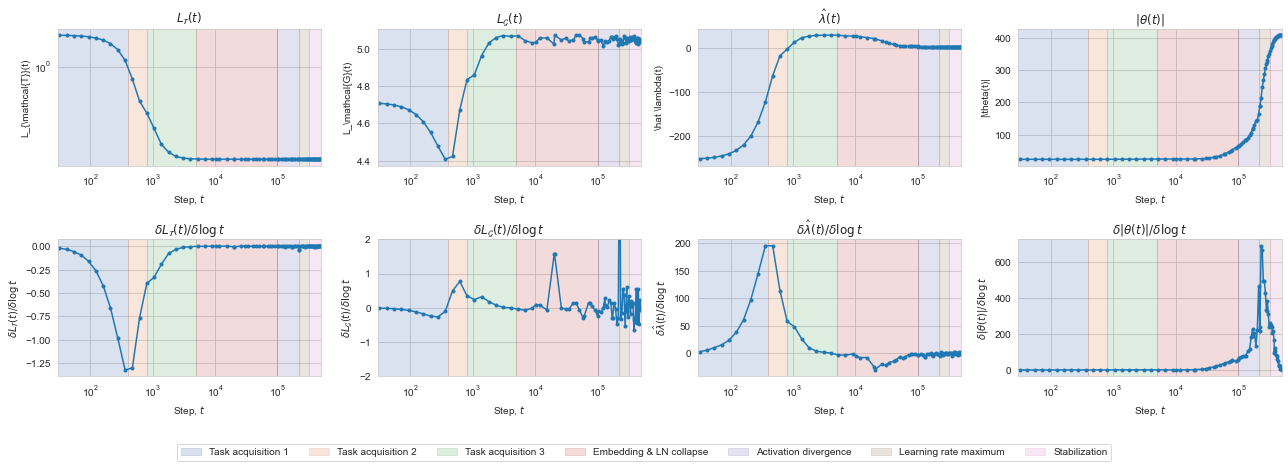

In [16]:
import seaborn as sns

def wrap_latex(s):
    return "$" + s + "$"

def add_d_dlogt(s):
    return wrap_latex(r"\delta " + s + r"/\delta\log t")

metrics_to_plot = [
    (r"L_{\mathcal{T}}(t)", evals_over_time_df["pretrain/mse"], {"logy": True}),
    (r"L_\mathcal{G}(t)", evals_over_time_df["true/mse"], {"logy": False}),
    (r"\hat \lambda(t)", llcs, {}),
    (r"|\theta(t)|", weight_norms, {}),
] 

metric_slopes = [
    # d_dt(run.checkpointer.file_ids, v) for _, v, __ in metrics_to_plot
    d_dlogt(run.checkpointer.file_ids, v) for _, v, __ in metrics_to_plot
]

fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(18, 6))

for i, (metric_name, metric_values, kwargs) in enumerate(metrics_to_plot):
    axes[0, i].plot(run.checkpointer.file_ids, metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(wrap_latex(metric_name))
    axes[0, i].set_xlabel('Step, $t$')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[1, i].plot(run.checkpointer.file_ids, metric_slopes[i], label=metric_name + " Slope", marker='.')
    axes[1, i].set_title(add_d_dlogt(metric_name))
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(add_d_dlogt(metric_name))

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(30, 500_000)

axes[1,1].set_ylim(-2, 2)

patch_list = add_milestones(axes)

milestone_labels = [label for _, _, label in MILESTONES]
fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(MILESTONES))

fig.set_facecolor("white")
fig.tight_layout()

## Functional (Loss, Midpoint-Distance, OOD loss)

In [17]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations
from devinfra.utils.iterables import flatten_dict

DEVICE = "mps"

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.pretrain_seed)

# shorthands
B = 1024
K = 8
D = 4

# sample a batch of random tasks
ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(B, K, D,),
    device=DEVICE
)

xs100 = 3 * xs
ys = apply_transformations(ws, xs, 0., DEVICE)
ys100 = apply_transformations(ws, xs100, 0., DEVICE)

def eval_loss(yhats, ys):
    losses = ((yhats - ys) ** 2).mean(dim=0)[:, 0]
    return [loss.item() for loss in losses] + [losses.mean().item()]

losses_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    losses = eval_loss(model(xs, ys), ys)
    loss100s = eval_loss(model(xs100, ys100), ys100)

    for i in range(9):
        losses_over_time.append({
            "step": step,
            "loss": losses[i],
            "loss100": loss100s[i],
            # "token": f"$\hat y_{i+1}$" if i < 8 else "$\overline{\hat y}$"
            "token": i + 1 if i < 8 else "$\overline{\hat y}$"
        })

losses_over_time = pd.DataFrame(losses_over_time)
losses_over_time

step      loss    loss100                token
0         0  2.034537  10.338282                    1
1         0  1.856782  10.510596                    2
2         0  1.999969  10.189651                    3
3         0  1.813184  10.118158                    4
4         0  1.922476  10.413272                    5
..      ...       ...        ...                  ...
859  499999  0.000003   0.004050                    5
860  499999  0.000004   0.003576                    6
861  499999  0.000005   0.004783                    7
862  499999  0.000004   0.003750                    8
863  499999  0.000003   0.003642  $\overline{\hat y}$

[864 rows x 4 columns]

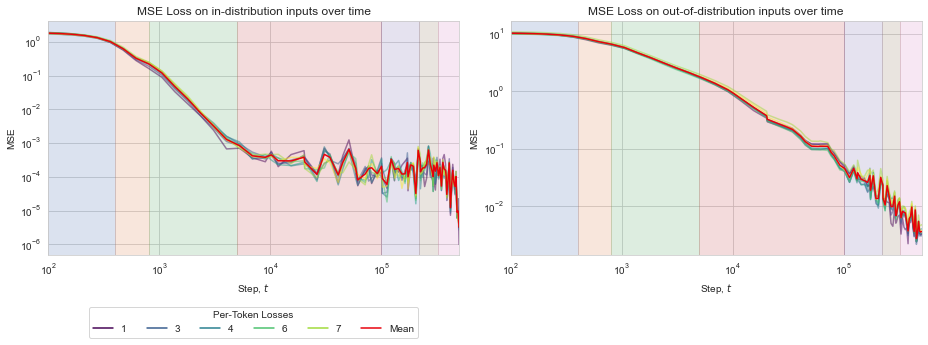

In [21]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 2, figsize=(20 * 2// 3, 5))

token_losses_over_time = losses_over_time.loc[losses_over_time.token != "$\overline{\hat y}$"]
mean_losses_over_time = losses_over_time.loc[losses_over_time.token == "$\overline{\hat y}$"]

sns.lineplot(data=token_losses_over_time, x="step", y=f"loss", hue="token", palette="viridis", ax=axes[0], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"loss100", hue="token", palette="viridis", ax=axes[1], alpha=0.5)

sns.lineplot(data=mean_losses_over_time, x="step", y="loss", label="Mean", ax=axes[0], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y="loss100", label="Mean", ax=axes[1], color=BRED)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Step, $t$")
    ax.set_yscale('log')
    legend = ax.legend()
    legend.remove()
    ax.set_xlim(100, 500_000)

legend = axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(MILESTONES))

axes[0].set_title("MSE Loss on in-distribution inputs over time")
axes[0].set_ylabel("MSE")
axes[1].set_title("MSE Loss on out-of-distribution inputs over time")
axes[1].set_ylabel("MSE")

add_milestones(axes)

for ax in axes:
    ax.set_xscale('log')

plt.tight_layout()
# Add color bar on the far right

fig.set_facecolor('white')

In [6]:
# Confirm that we've loaded in the most recent model
run.evaluator(run.model)

{'pretrain/mse': 0.12384558469057083,
 'pretrain/delta_dmmse': tensor(3.2642e-06, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.4832, device='mps:0'),
 'pretrain/token/0': 0.1295662224292755,
 'pretrain/token/1': 0.11029980331659317,
 'pretrain/token/2': 0.12545500695705414,
 'pretrain/token/3': 0.13209488987922668,
 'pretrain/token/4': 0.12364320456981659,
 'pretrain/token/5': 0.12712566554546356,
 'pretrain/token/6': 0.12184036523103714,
 'pretrain/token/7': 0.12073952704668045,
 'true/mse': 5.095541954040527,
 'true/delta_dmmse': tensor(7.0409e-06, device='mps:0'),
 'true/delta_ridge': tensor(3.3719, device='mps:0'),
 'true/token/0': 5.287389755249023,
 'true/token/1': 5.492504119873047,
 'true/token/2': 4.828819274902344,
 'true/token/3': 5.2150373458862305,
 'true/token/4': 5.465460777282715,
 'true/token/5': 4.597151279449463,
 'true/token/6': 5.205916881561279,
 'true/token/7': 4.672055721282959}

In [7]:
list(run.model.state_dict().keys())

['token_sequence_transformer.token_embedding.weight',
 'token_sequence_transformer.postn_embedding.weight',
 'token_sequence_transformer.blocks.0.attention.causal_mask',
 'token_sequence_transformer.blocks.0.attention.attention.weight',
 'token_sequence_transformer.blocks.0.compute.0.weight',
 'token_sequence_transformer.blocks.0.compute.0.bias',
 'token_sequence_transformer.blocks.0.compute.2.weight',
 'token_sequence_transformer.blocks.0.compute.2.bias',
 'token_sequence_transformer.blocks.0.layer_norms.0.weight',
 'token_sequence_transformer.blocks.0.layer_norms.0.bias',
 'token_sequence_transformer.blocks.0.layer_norms.1.weight',
 'token_sequence_transformer.blocks.0.layer_norms.1.bias',
 'token_sequence_transformer.blocks.1.attention.causal_mask',
 'token_sequence_transformer.blocks.1.attention.attention.weight',
 'token_sequence_transformer.blocks.1.compute.0.weight',
 'token_sequence_transformer.blocks.1.compute.0.bias',
 'token_sequence_transformer.blocks.1.compute.2.weight',
 

In [8]:
from typing import List
from torchtyping import TensorType


def get_attention(model, xs, ys):
    num_layers = len(model.token_sequence_transformer.blocks)
    probes = []

    for b in range(num_layers):
        probe = ActivationProbe(model, f"token_sequence_transformer.blocks.{b}.attention.attention_softmax")
        probe.register_hook()
        probes.append(probe)

    # Run the model
    model(xs, ys)

    for probe in probes:
        probe.unregister_hook()

    # Get the activations
    return [probe.activation for probe in probes]

def plot_activations(activations: List[TensorType["batch", "heads", "tokens", "tokens"]]):       
    num_layers = len(activations)
    num_samples, num_heads, num_tokens, _ = activations[0].shape

    for sample_idx in range(num_samples):
        # Create a new figure
        plt.figure(figsize=(15, 4 * num_layers))

        # Loop through each head
        for layer_idx, activation in enumerate(activations):
            for head_idx in range(num_heads):
                head_activation = activation[sample_idx, head_idx].detach().cpu().numpy()

                # Create a subplot for each head
                ax = plt.subplot(num_layers, num_heads, layer_idx * num_heads + head_idx + 1)

                # Plot the activation
                ax.imshow(head_activation, cmap='viridis', aspect='auto')

                # Add title and labels
                ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
                ax.set_xlabel('Keys')
                ax.set_ylabel('Queries')

        plt.tight_layout()
        plt.show()

def compose2(f, g):
    return lambda *a, **kw: f(g(*a, **kw))

def compose(*fs):
    from functools import reduce
    return reduce(compose2, fs)

get_and_plot_activations = compose(plot_activations, get_attention)

In [8]:
ws = run.pretrain_dist.task_distribution.tasks
print(ws)

tensor([[0.6614, 0.2669, 0.0617, 0.6213]], device='mps:0')


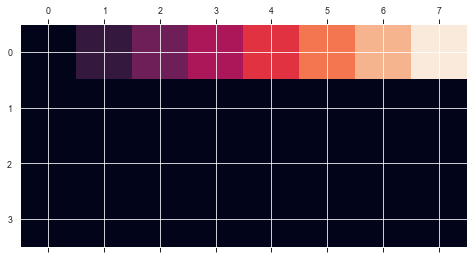

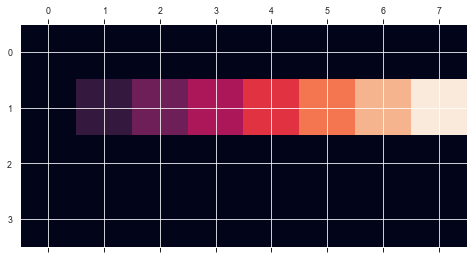

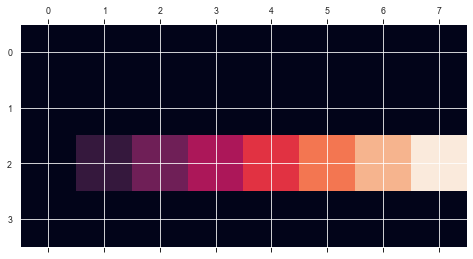

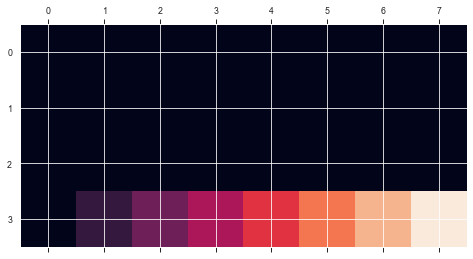

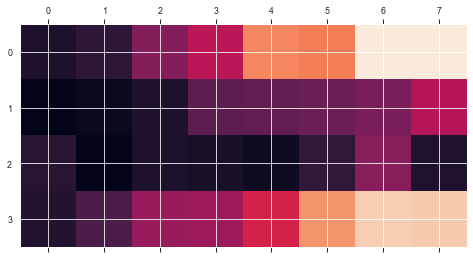

In [9]:
from icl.tasks import apply_transformations

# x_trick = torch.zeros((4, 8, 4))
# x_trick[:, :, 0] = torch.arange(0, 8)
# # y_trick = torch.zeros((1, 8, 1))
# x_trick = x_trick.to("mps")
# y_trick = apply_transformations(ws, x_trick, run.pretrain_dist.std, device="mps")

x_trick = torch.zeros((4, 8, 4))
for i in range(4):
    x_trick[i, :, i] = torch.arange(0, 8)

# y_trick = torch.zeros((1, 8, 1))
x_trick = x_trick.to("mps")
y_trick = apply_transformations(ws[0].repeat(4), x_trick, run.pretrain_dist.std, device="mps")

for i in range(4):
    plt.matshow(x_trick[i].T.detach().cpu().numpy())

plt.matshow(y_trick.detach().cpu().numpy())

In [9]:
# xs, ys = run.pretrain_dist.get_batch(8, 1)
# get_and_plot_activations(run.model, xs=xs, ys=ys)
get_and_plot_activations(run.model, xs=x_trick, ys=y_trick)

NameError: name 'x_trick' is not defined

In [ ]:
run_2 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 65536, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_2, ys_2 = run_2.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_2.model, xs=xs_2, ys=ys_2)
get_and_plot_activations(run_2.model, xs=x_trick, ys=y_trick)

In [ ]:
run_3 = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 64, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

xs_3, ys_3 = run_3.pretrain_dist.get_batch(8, 1)
get_and_plot_activations(run_3.model, xs=xs_3, ys=ys_3)
get_and_plot_activations(run_3.model, xs=x_trick, ys=y_trick)

# Reverse Engineering

In [10]:
import numpy as np
from icl.model import from_predicted_token_sequence, to_token_sequence

activations = []

class EmbedUnembedOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        # unembedded = self.unembedding[0](x)
        unembedded = self.unembedding[1](x / 25)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


embed_unembed_only_model = EmbedUnembedOnly(run.model)
run.evaluator(embed_unembed_only_model)

{'pretrain/mse': 0.1272483468055725,
 'pretrain/delta_dmmse': tensor(0.0032, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.4455, device='mps:0'),
 'pretrain/token/0': 0.13374899327754974,
 'pretrain/token/1': 0.11237277090549469,
 'pretrain/token/2': 0.1297406107187271,
 'pretrain/token/3': 0.13376107811927795,
 'pretrain/token/4': 0.12727957963943481,
 'pretrain/token/5': 0.13120131194591522,
 'pretrain/token/6': 0.12555132806301117,
 'pretrain/token/7': 0.12433113902807236,
 'true/mse': 4.994413375854492,
 'true/delta_dmmse': tensor(0.0033, device='mps:0'),
 'true/delta_ridge': tensor(3.2730, device='mps:0'),
 'true/token/0': 5.189401149749756,
 'true/token/1': 5.38076114654541,
 'true/token/2': 4.716647148132324,
 'true/token/3': 5.119599342346191,
 'true/token/4': 5.341472625732422,
 'true/token/5': 4.512819766998291,
 'true/token/6': 5.117273330688477,
 'true/token/7': 4.577332496643066}

In [11]:
hooked_model = hook(run.model)

In [12]:
activations = hooked_model.run_with_cache(run.evaluator.pretrain_xs, run.evaluator.pretrain_ys)[1]
activations.keys()

dict_keys(['token_sequence_transformer', 'token_sequence_transformer.token_embedding', 'token_sequence_transformer.postn_embedding', 'token_sequence_transformer.blocks.0', 'token_sequence_transformer.blocks.0.attention', 'token_sequence_transformer.blocks.0.attention.attention', 'token_sequence_transformer.blocks.0.attention.attention_softmax', 'token_sequence_transformer.blocks.0.compute.0', 'token_sequence_transformer.blocks.0.compute.1', 'token_sequence_transformer.blocks.0.compute.2', 'token_sequence_transformer.blocks.0.layer_norms.0', 'token_sequence_transformer.blocks.0.layer_norms.1', 'token_sequence_transformer.blocks.0.resid_after_attn', 'token_sequence_transformer.blocks.1', 'token_sequence_transformer.blocks.1.attention', 'token_sequence_transformer.blocks.1.attention.attention', 'token_sequence_transformer.blocks.1.attention.attention_softmax', 'token_sequence_transformer.blocks.1.compute.0', 'token_sequence_transformer.blocks.1.compute.1', 'token_sequence_transformer.bloc

TypeError: Image data of dtype <U26 cannot be converted to float

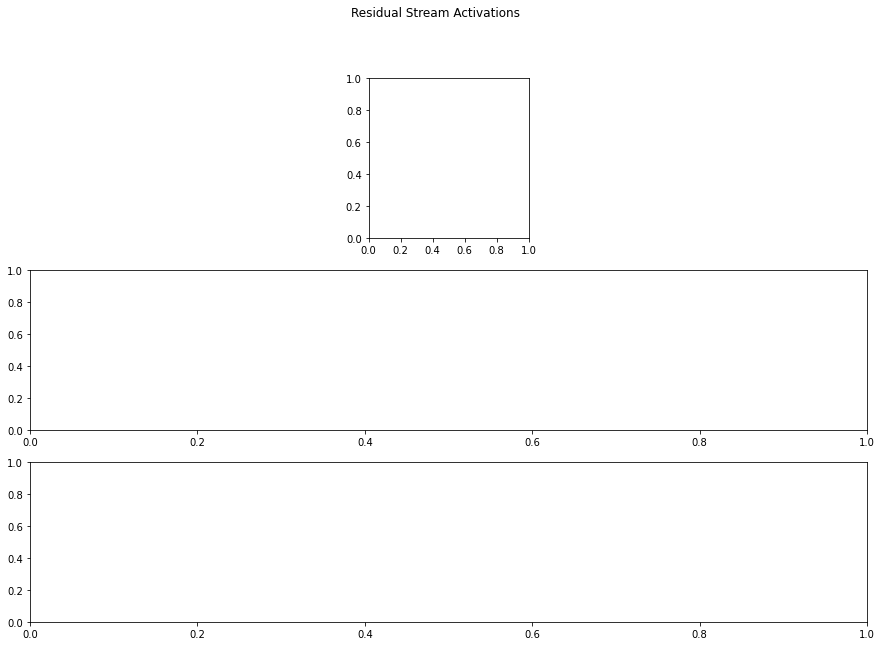

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
plt.suptitle("Residual Stream Activations")

for ax, activation, label in zip(axes, activations, ["Embedding", "Block 1", "Block 2"]):
    cax = ax.matshow(activation)
    ax.set_title(f"After {label}")
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Token")
    fig.colorbar(cax, ax=ax)

plt.tight_layout()
plt.show()

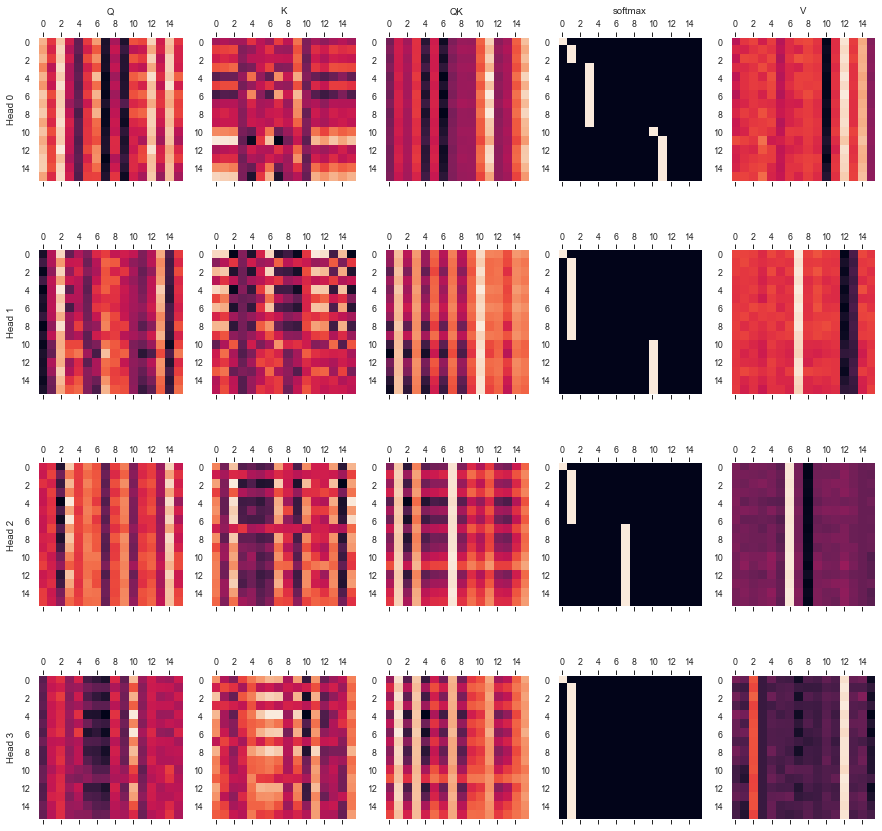

In [15]:

def separate_attention(qkv, num_heads, batch_size, head_size, num_tokens):
    return (qkv.view(batch_size, num_tokens, num_heads, 3*head_size)
            .transpose(-2, -3)
            .split(head_size, dim=-1))

def plot_matrix(ax, data, title: Optional[str] = None):
    ax.matshow(data.detach().to("cpu").numpy())
    ax.grid(None)

    if title is not None:
        ax.set_title(title)

def plot_attention(axs, data, titles, num_heads):
    q, k, softmax, v  = data
    qk = (q.unsqueeze(0) @ k.unsqueeze(0).transpose(-2, -1))[0]

    # Rows for each head
    # Columns for Q, K, QK, V
    for j, (name, x) in enumerate(zip(titles, [q, k, qk, softmax, v])):
        axs[0, j].set_title(name)

        for h in range(num_heads):
            plot_matrix(axs[h, j], x[h])

    for h in range(num_heads):
        axs[h, 0].set_ylabel(f"Head {h}")


fig, axes = plt.subplots(4, 5, figsize=(15, 15))
softmax = activations["token_sequence_transformer.blocks.0.attention.attention_softmax"]
q, k, v = separate_attention(activations["token_sequence_transformer.blocks.0.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)
attn = [q[0], k[0], softmax[0], v[0]]
plot_attention(axes, attn, ["Q", "K", "QK", "softmax", "V"], num_heads=4)

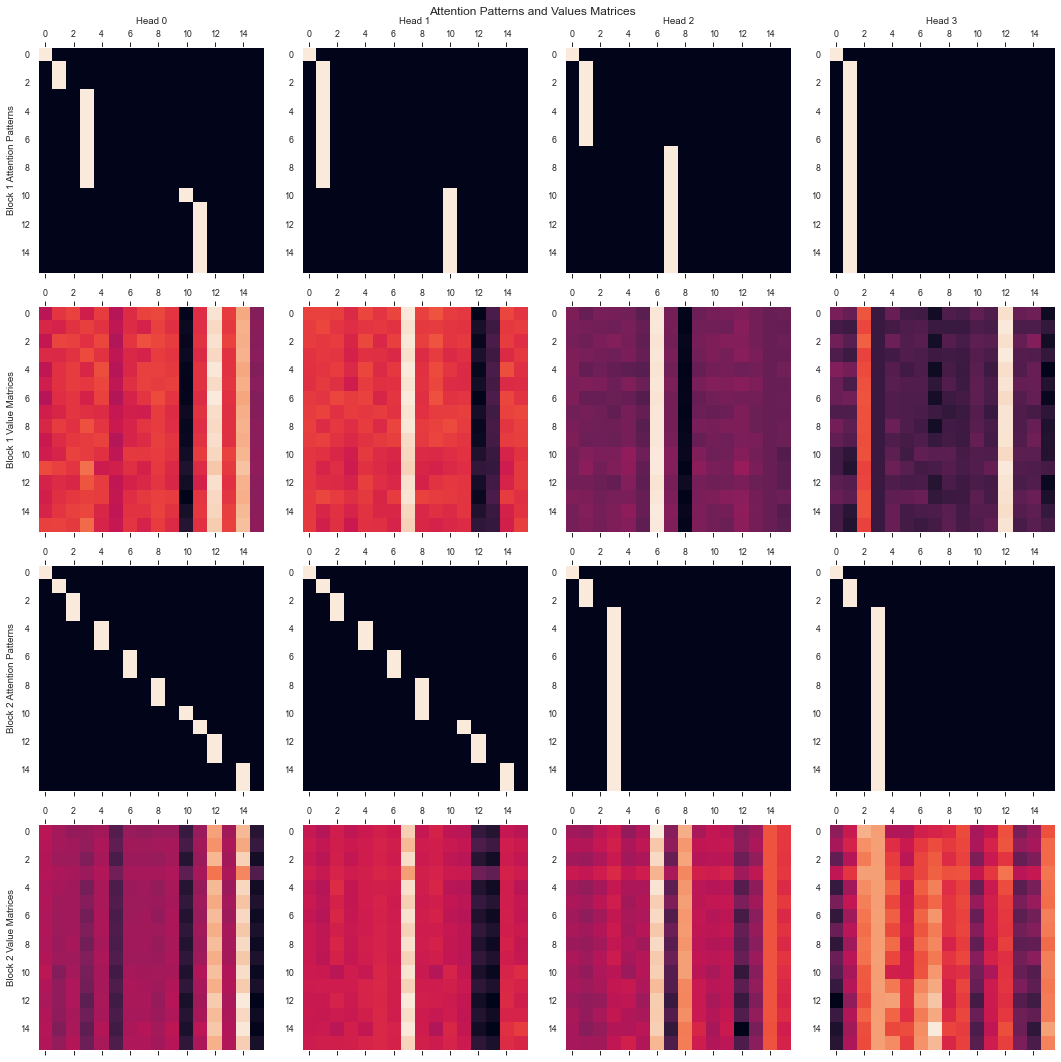

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

softmax0 = activations["token_sequence_transformer.blocks.0.attention.attention_softmax"][0]
v0 = separate_attention(activations["token_sequence_transformer.blocks.0.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)[-1][0]

softmax1 = activations["token_sequence_transformer.blocks.1.attention.attention_softmax"][0]
v1 = separate_attention(activations["token_sequence_transformer.blocks.1.attention.attention"], 4, len(run.evaluator.pretrain_xs), 16, 16)[-1][0]

labels = ["Block 1 Attention Patterns", "Block 1 Value Matrices", "Block 2 Attention Patterns", "Block 2 Value Matrices"]

for r, (layer, label) in enumerate(zip([softmax0, v0, softmax1, v1], labels)):
    axes[r, 0].set_ylabel(label)
    for c, x in enumerate(layer):
        plot_matrix(axes[r, c], x, title=None)

for c, label in enumerate(labels):
    axes[0, c].set_title(f"Head {c}")

plt.suptitle("Attention Patterns and Values Matrices")
plt.tight_layout()
plt.savefig("../figures/m1-attn.png", dpi=300)
plt.show()

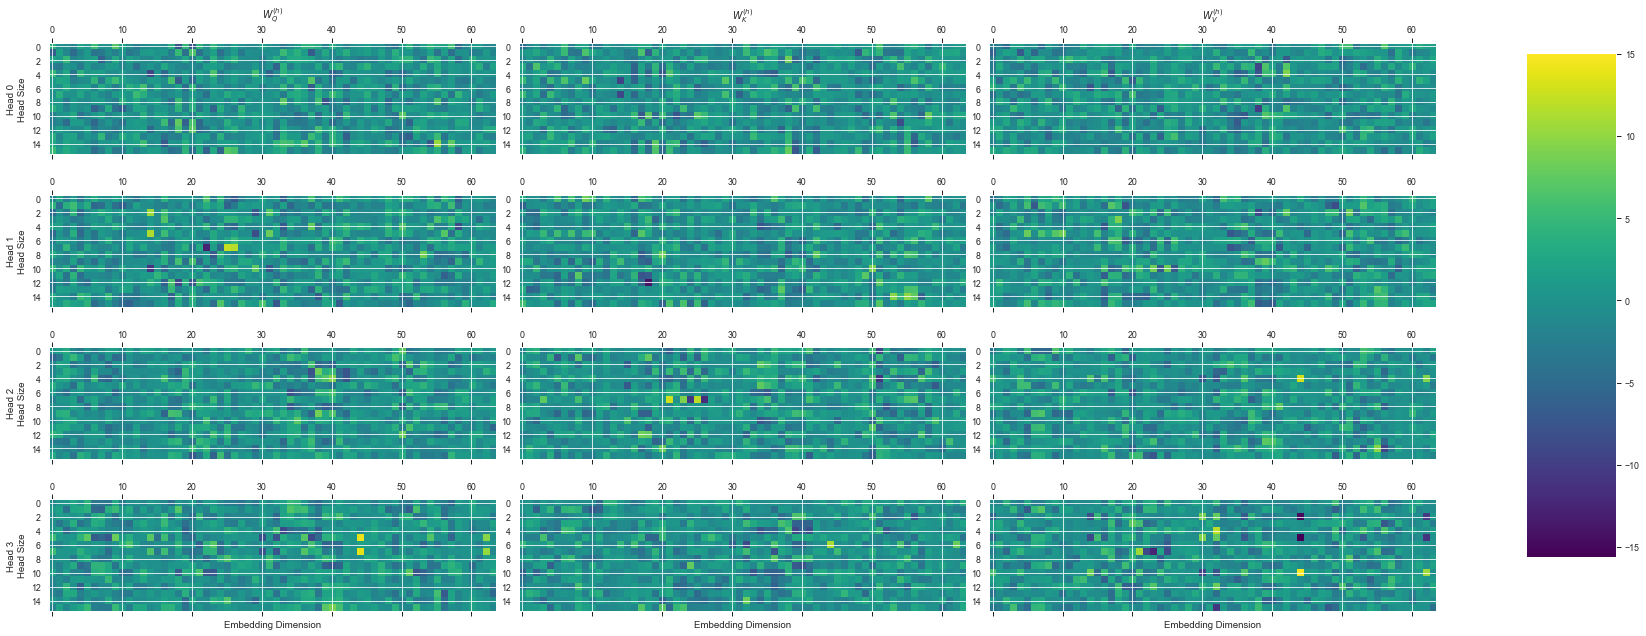

In [17]:

mat = run.model.token_sequence_transformer.blocks[0].attention.attention.weight.flatten() # .detach().to("cpu").numpy().reshap

def plot_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int, cols=("$W_Q^{(h)}$", "$W_K^{(h)}$", "$W_V^{(h)}$"), title="", save: Optional[str] = None, rows:Optional[List[str]] =None):
    if len(W.shape) == 1:  # Num heads * Embedding dimension * Head size * 3
        heads = list(split_attn_weights(W, num_heads, embed_dim, head_size))
    elif len(W.shape) == 3:  # Num heads, Embedding dimension, Head size * 3
        heads = [tuple(W[:, h, i*head_size:(i+1)*head_size].T for i in range(3)) for h in range(num_heads)]
    else:
        raise ValueError(f"Expected W to have shape (num_heads, embed_dim, head_size * 3) or (num_heads * embed_dim * head_size * 3), got {W.shape}")

    fig, axs = plt.subplots(num_heads, 3, figsize=(25, 10))
    plt.suptitle(title)

    rows = rows or [f"Head {h}" for h in range(num_heads)]

    min_, max_ = W.min(), W.max()

    for h, head in enumerate(heads):
        axs[h, 0].set_ylabel(f"{rows[h]}\nHead Size")

        for i, mat in enumerate(head):
            axs[h, i].matshow(mat.detach().cpu().numpy().T, cmap='viridis', vmin=min_, vmax=max_) 

    for i, col in enumerate(cols):
        axs[0, i].set_title(col)
        axs[-1, i].set_xlabel("Embedding Dimension")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Plot colorbar somewhere on right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(axs[0, 0].images[0], cax=cbar_ax)
    

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


plot_attn_weights(mat, 4, 64, 16)

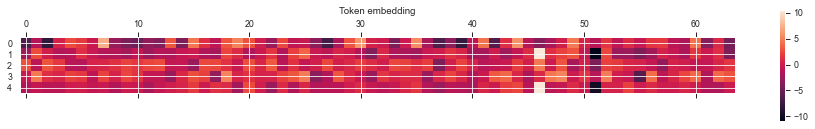

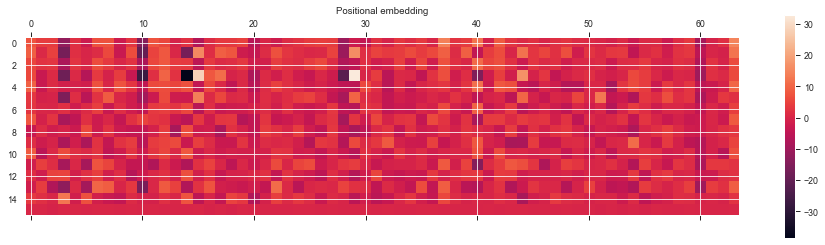

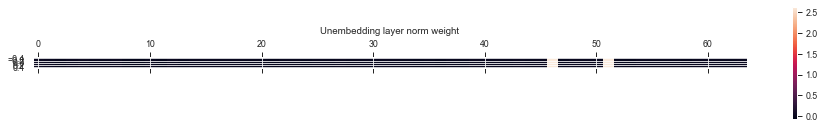

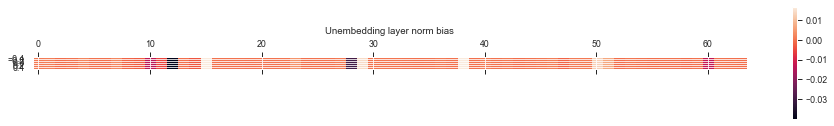

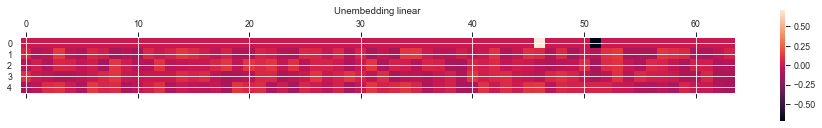

NameError: name 'np' is not defined

In [5]:
import seaborn as sns
sns.set_theme("paper")

plt.matshow(run.model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy().T)
plt.title("Token embedding")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.postn_embedding.weight.detach().cpu().numpy().T)
plt.title("Positional embedding")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.unembedding[0].weight.unsqueeze(0).detach().cpu().numpy())
plt.title("Unembedding layer norm weight")
plt.colorbar()
plt.show()


plt.matshow(run.model.token_sequence_transformer.unembedding[0].bias.unsqueeze(0).detach().cpu().numpy())
plt.title("Unembedding layer norm bias")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy())
plt.title("Unembedding linear")
plt.colorbar()
plt.show()

# Please plot the layernorm weights and biases together as a histogram

plt.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].weight.detach().cpu().numpy().flatten(), label="weight")
plt.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].bias.detach().cpu().numpy().flatten(), label="bias")
plt.legend()
plt.xlabel("Dimension")
plt.title("Unembedding Layer Norm")
plt.show()

plt.bar(np.arange(64), run.model.token_sequence_transformer.blocks[0].compute[2].bias.detach().cpu().numpy().flatten(), label="Block 0")
plt.bar(np.arange(64), run.model.token_sequence_transformer.blocks[1].compute[2].bias.detach().cpu().numpy().flatten(), label="Block 1")
plt.legend()
plt.xlabel("Dimension")
plt.title("MLP Projection Bias")
plt.show()

In [118]:
run.model.token_sequence_transformer.token_embedding.weight.shape

torch.Size([64, 5])

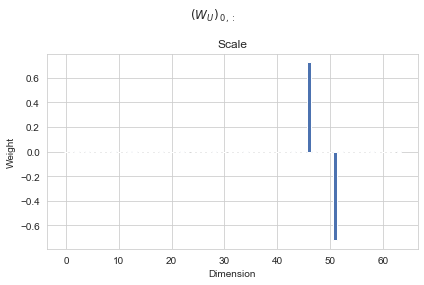

In [24]:

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(1, 1)  # Adjust figsize to desired size

# Plot the weight on the first subplot (ax)
ax.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[1].weight[0, :].detach().cpu().numpy().flatten())
ax.set_ylabel('Weight')
ax.set_xlabel("Dimension")
ax.set_title("Scale")

# Set a main title for the entire figure
plt.suptitle("$(W_U)\,_{0,:}$")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

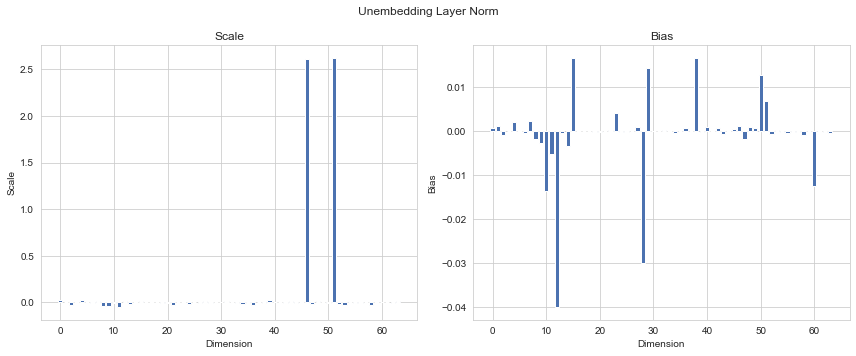

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize to desired size

# Plot the weight on the first subplot (ax1)
ax1.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].weight.detach().cpu().numpy().flatten())
ax1.set_ylabel('Scale')
ax1.set_xlabel("Dimension")
ax1.set_title("Scale")

# Plot the bias on the second subplot (ax2)
ax2.bar(np.arange(64), run.model.token_sequence_transformer.unembedding[0].bias.detach().cpu().numpy().flatten())
ax2.set_ylabel('Bias')
ax2.set_xlabel("Dimension")
ax2.set_title("Bias")

# Set a main title for the entire figure
plt.suptitle("Unembedding Layer Norm")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [88]:
embed46 = run.model.token_sequence_transformer.token_embedding.weight[46]
embed51 = run.model.token_sequence_transformer.token_embedding.weight[51]

with torch.no_grad():
    embed46[0] = 0
    embed51[0] = 0


print("Task weights (normalized):", (run.pretrain_dist.task_distribution.tasks / run.pretrain_dist.task_distribution.tasks.sum()).tolist())
print("Embedding weights (index 46):", (embed46).tolist())
print("Embedding weights (index 51):", (embed51).tolist())
print("Embedding weights (index 46, normalized):", (embed46 / embed46.sum()).tolist())
print("Embedding weights (index 51, normalized):", (embed51 / embed51.sum()).tolist())
print("Embedding weights (averaged across indices 46 and 51, normalized):", ((embed46 / embed46.sum() + embed51 / embed51.sum()) / 2).tolist())


Task weights (normalized): [[0.410453736782074, 0.16566060483455658, 0.03827863931655884, 0.3856070041656494]]
Embedding weights (index 46): [0.0, 10.62821102142334, 4.615780353546143, 0.8649820685386658, 10.451982498168945]
Embedding weights (index 51): [0.0, -10.933765411376953, -4.078135967254639, -1.1483864784240723, -9.843438148498535]
Embedding weights (index 46, normalized): [0.0, 0.40014415979385376, 0.1737806648015976, 0.032565925270318985, 0.39350929856300354]
Embedding weights (index 51, normalized): [-0.0, 0.42046919465065, 0.15682891011238098, 0.044162385165691376, 0.3785395324230194]
Embedding weights (averaged across indices 46 and 51, normalized): [0.0, 0.4103066921234131, 0.1653047800064087, 0.03836415708065033, 0.3860244154930115]


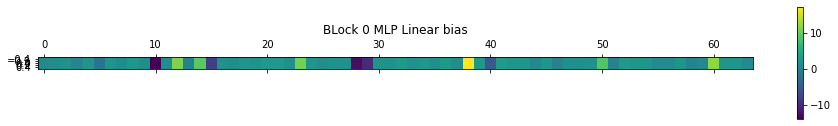

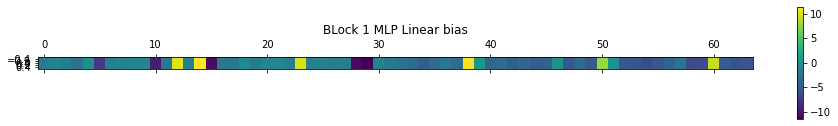

In [87]:
plt.matshow(run.model.token_sequence_transformer.blocks[0].compute[2].bias.unsqueeze(0).cpu().detach().numpy())
plt.title("BLock 0 MLP Linear bias")
plt.colorbar()
plt.show()

plt.matshow(run.model.token_sequence_transformer.blocks[1].compute[2].bias.unsqueeze(0).cpu().detach().numpy())
plt.title("BLock 1 MLP Linear bias")
plt.colorbar()
plt.show()

In [165]:
sum(p.numel() for p in run.model.parameters()) 

43525

In [167]:
run.model.state_dict().keys()

odict_keys(['token_sequence_transformer.token_embedding.weight', 'token_sequence_transformer.postn_embedding.weight', 'token_sequence_transformer.blocks.0.attention.causal_mask', 'token_sequence_transformer.blocks.0.attention.attention.weight', 'token_sequence_transformer.blocks.0.compute.0.weight', 'token_sequence_transformer.blocks.0.compute.0.bias', 'token_sequence_transformer.blocks.0.compute.2.weight', 'token_sequence_transformer.blocks.0.compute.2.bias', 'token_sequence_transformer.blocks.0.layer_norms.0.weight', 'token_sequence_transformer.blocks.0.layer_norms.0.bias', 'token_sequence_transformer.blocks.0.layer_norms.1.weight', 'token_sequence_transformer.blocks.0.layer_norms.1.bias', 'token_sequence_transformer.blocks.1.attention.causal_mask', 'token_sequence_transformer.blocks.1.attention.attention.weight', 'token_sequence_transformer.blocks.1.compute.0.weight', 'token_sequence_transformer.blocks.1.compute.0.bias', 'token_sequence_transformer.blocks.1.compute.2.weight', 'token

Text(0.5, 0.98, 'PCA of embedding')

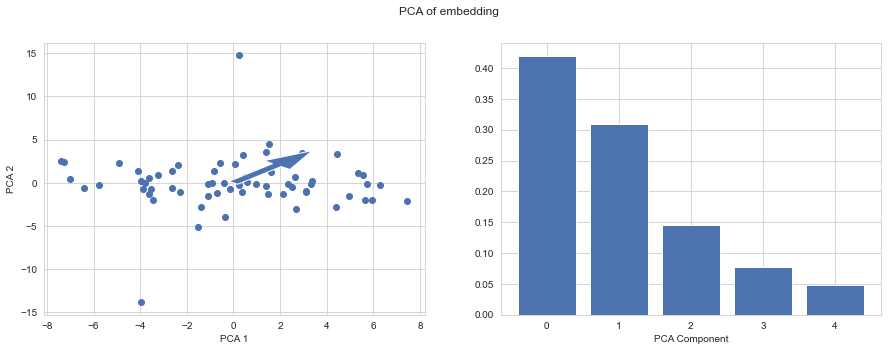

In [130]:
# Let's look at the variance and mean of activations in the residual stream over time. I want to see this for different points of the model
from sklearn.decomposition import PCA

embedding = run.model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()

pca = PCA(n_components=5)
pca.fit(embedding)

pca_embedding = pca.transform(embedding)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(pca_embedding[:, 0], pca_embedding[:, 1])
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

axes[1].bar(np.arange(5), pca.explained_variance_ratio_)
axes[1].set_xlabel("PCA Component")


task_embed_reduced = pca.transform(task_embed.reshape(1, -1)) * 3

axes[0].arrow(0, 0, task_embed_reduced[0, 0], task_embed_reduced[0, 1], width=0.5)

plt.suptitle("PCA of embedding")

# Development

In [9]:
from tqdm import tqdm
from copy import deepcopy

models = []

for state_dict in tqdm(run.checkpointer):
    model = deepcopy(run.model)
    model.load_state_dict(state_dict["model"])
    models.append(model)

100%|██████████| 96/96 [01:55<00:00,  1.20s/it]


In [10]:
steps = run.checkpointer.file_ids

In [16]:
dr_embeddings_over_time = [
    pca.transform(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
    for model in models
]

In [132]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('3D PCA', 'Explained Variance'),
    column_widths=[0.7, 0.3],
    specs=[[{'type': 'scatter3d'}, {'type': 'bar'}]]
)

# Create frames for each PCA projection and explained variance
frames = [
    go.Frame(
        data=[
            go.Scatter3d(
            x=embed[:, 0], 
            y=embed[:, 1], 
            z=embed[:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
            # go.Bar(
            #     x=list(range(1, len(pca_proj[1].explained_variance_ratio_) + 1)),
            #     y=pca_proj[1].explained_variance_ratio_,
            #     name="Explained Variance",
            # )
            go.Scatter3d(
                x=[0, task_embed_reduced[0, 0]], y=[0, task_embed_reduced[0, 1]], z=[0, task_embed_reduced[0, 2]],
                mode='lines+markers',
                line=dict(width=5.0, color='red'),
                marker=dict(size=[0, 6], color=['red', 'red'], symbol=['circle', 'cross']),
                name='Arrow'
            ),
        ],
        name=str(i)
    ) for i, embed in enumerate(dr_embeddings_over_time)
]

# Add frames to figure
fig.frames = frames

# Add initial data
fig.add_trace(
     go.Scatter3d(
            x=dr_embeddings_over_time[0][:, 0], 
            y=dr_embeddings_over_time[0][:, 1], 
            z=dr_embeddings_over_time[0][:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
    row=1, col=1
)


fig.add_trace(
    go.Scatter3d(
        x=[0, task_embed_reduced[0, 0]], y=[0, task_embed_reduced[0, 1]], z=[0, task_embed_reduced[0, 2]],
        mode='lines+markers',
        line=dict(width=5.0, color='red'),
        marker=dict(size=[0, 6], color=['red', 'red'], symbol=['circle', 'cross']),
        name='Arrow'
    ),
    row=1, col=1
)

# fig.add_trace(
#     go.Bar(
#         x=list(range(1, len(embed[1].explained_variance_ratio_) + 1)),
#         y=embed[1].explained_variance_ratio_,
#         name="Explained Variance",
#     ),
#     row=1, col=2
# )

# Create slider steps
steps = [
    dict(
        args=[[frame.name], {"frame": {"duration": 100, "redraw": True},
                             "mode": "immediate",
                             "transition": {"duration": 100}}],
         label=str(step), 
              method="animate") for step, frame in zip(run.checkpointer.file_ids, frames)]


# Add slider and play button
sliders = [dict(steps=steps,
                active=0,
                yanchor='top',
                xanchor='left',
                currentvalue={
                    "font": {"size": 20},
                    "prefix": "Model:",
                    "visible": True,
                    "xanchor": "right"
                },
                transition={"duration": 300, "easing": "cubic-in-out"})]
fig.update_layout(
    updatemenus=[
        dict(type="buttons",
             showactive=False,
             buttons=[
                 dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 200, "redraw": True},
                                   "fromcurrent": True,
                                   "transition": {"duration": 200}}])
             ])
    ],
    sliders=sliders,
    yaxis1=dict(range=[0, 1])
)

fig.show()


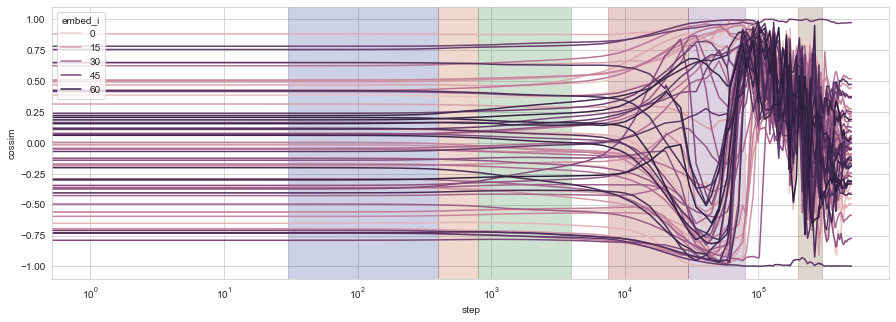

In [168]:
all_cossims_over_time = pd.DataFrame([entry for model, step in zip(models, run.checkpointer.file_ids) for entry in [
    {
        "cossim": np.dot(e, task_embed) / (np.linalg.norm(e) * np.linalg.norm(task_embed)),
        "embed_i": i,
        "step": step
    }
    for i, e in enumerate(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
]])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_over_time, x="step", y="cossim", hue="embed_i", ax=ax)
ax.set_xscale('log')

# Milestones
for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


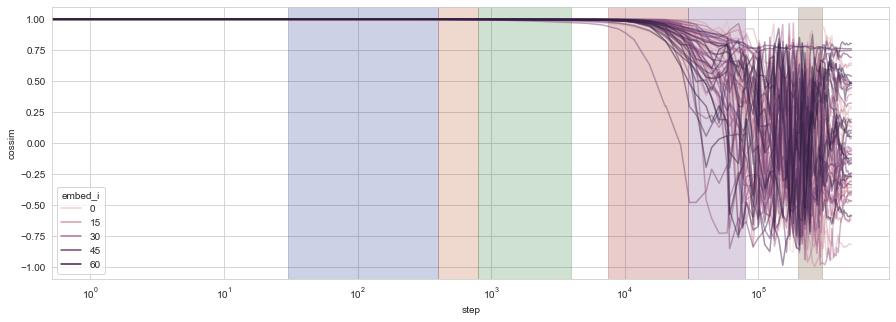

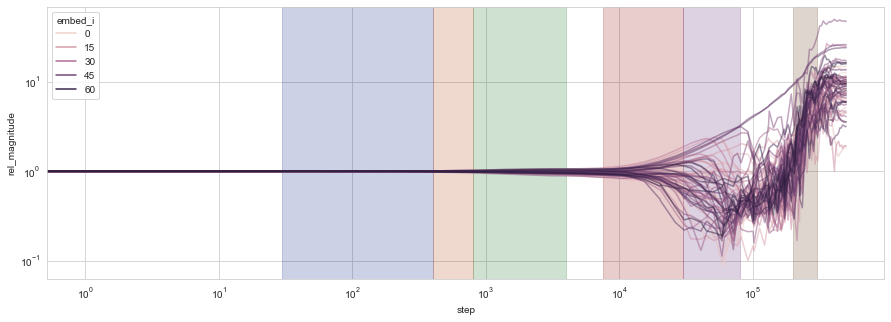

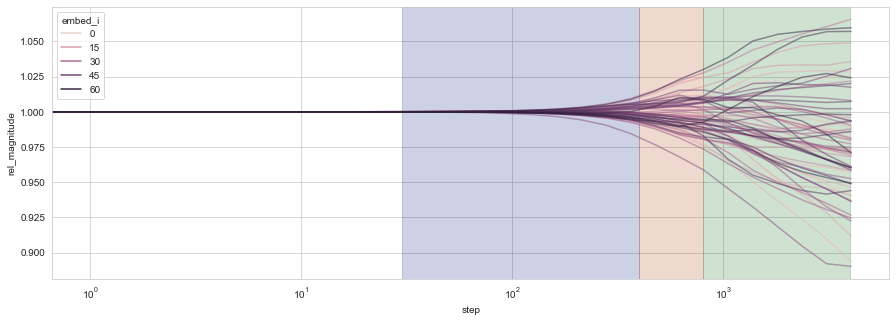

In [183]:
# Let's look at the cossims of each of the embedding vectors with their original value over time
init_embeds = models[0].token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()


all_cossims_with_init_over_time = pd.DataFrame([entry for model, step in zip(models, run.checkpointer.file_ids) for entry in [
    {
        "cossim": np.dot(e, init_embeds[i]) / (np.linalg.norm(e) * np.linalg.norm(init_embeds[i])),
        "rel_magnitude": np.linalg.norm(e) / np.linalg.norm(init_embeds[i]),
        "embed_i": i,
        "step": step
    }
    for i, e in enumerate(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
]])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="cossim", hue="embed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="rel_magnitude", hue="embed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time.loc[all_cossims_with_init_over_time.step < 5000], x="step", y="rel_magnitude", hue="embed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    end = min(end, 5000)

    if start < 5000:
        ax.axvspan(start, end, alpha=0.2, label=label, color=color)


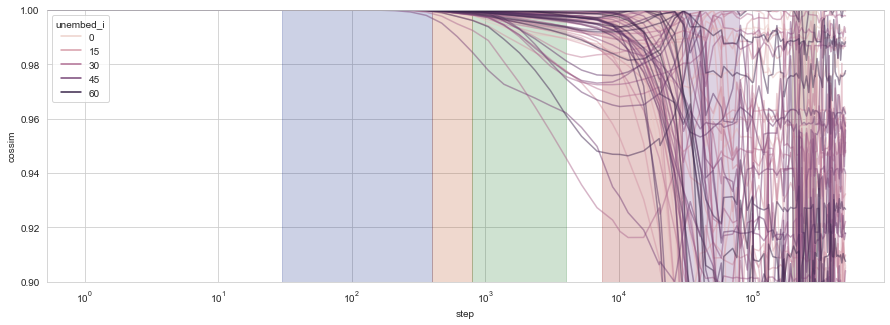

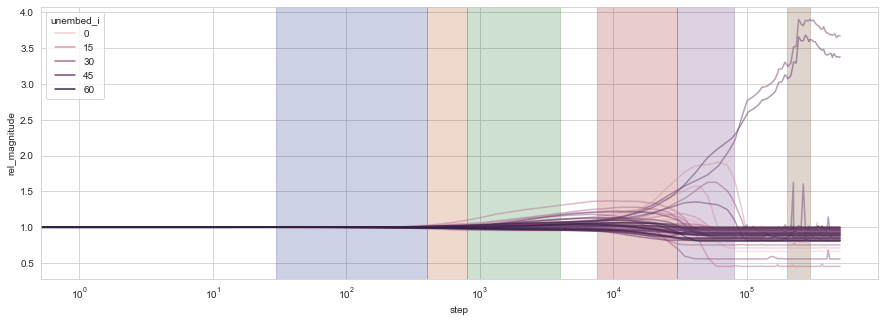

In [178]:
# Let's look at the cossims of each of the unembedding vectors with their original value over time
init_unembeds = models[0].token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy().T

all_cossims_with_init_over_time = pd.DataFrame([entry for model, step in zip(models, run.checkpointer.file_ids) for entry in [
    {
        "cossim": np.dot(e, init_unembeds[i]) / (np.linalg.norm(e) * np.linalg.norm(init_unembeds[i])),
        "1_min_cossim": 1 - np.dot(e, init_unembeds[i]) / (np.linalg.norm(e) * np.linalg.norm(init_unembeds[i])),
        "rel_magnitude": np.linalg.norm(e) / np.linalg.norm(init_unembeds[i]),
        "unembed_i": i,
        "step": step
    }
    for i, e in enumerate(model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy().T)
]])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="cossim", hue="unembed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

ax.set_ylim(0.9, 1.)

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=all_cossims_with_init_over_time, x="step", y="rel_magnitude", hue="unembed_i", ax=ax, alpha=0.5)
ax.set_xscale('log')

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)


In [203]:
# I want to look at the cossims of the activation vectors with the original value over time

activations = []

resid_layers = [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.blocks.0.resid_after_attn",
    "token_sequence_transformer.blocks.0",
    "token_sequence_transformer.blocks.1.resid_after_attn",
    "token_sequence_transformer.blocks.1",
    "token_sequence_transformer.unembedding.0"       
]

init_activations = {}

for step, model in tqdm(zip(run.checkpointer.file_ids, models)):
    model.to('mps')
    hooked_model = hook(model)
    model_acts = []

    for x in torch.eye(4, device="mps"):
        y = torch.zeros((1, 1, 1), device="mps")
        model_acts.append(hooked_model.run_with_cache(x.unsqueeze(0).unsqueeze(0), y)[1])

    cossims = []

    for j, layer in enumerate(resid_layers):
        layer_acts = torch.stack([acts[layer] for acts in model_acts])[:, 0, 0, :].T.detach().cpu().numpy()

        if step == 0:
            init_activations[layer]= layer_acts

        init_acts = init_activations[layer]
        cossims.append([np.dot(layer_acts[i], init_acts[i]) / (np.linalg.norm(layer_acts[i]) * np.linalg.norm(init_acts[i])) for i in range(64)])

    for i in range(64):
        activations.append({
            "step": step,
            **{layer: cossim[i] for layer, cossim in zip(resid_layers, cossims)},
            "embed_i": i
        })

activations = pd.DataFrame(activations)


96it [00:02, 37.53it/s]


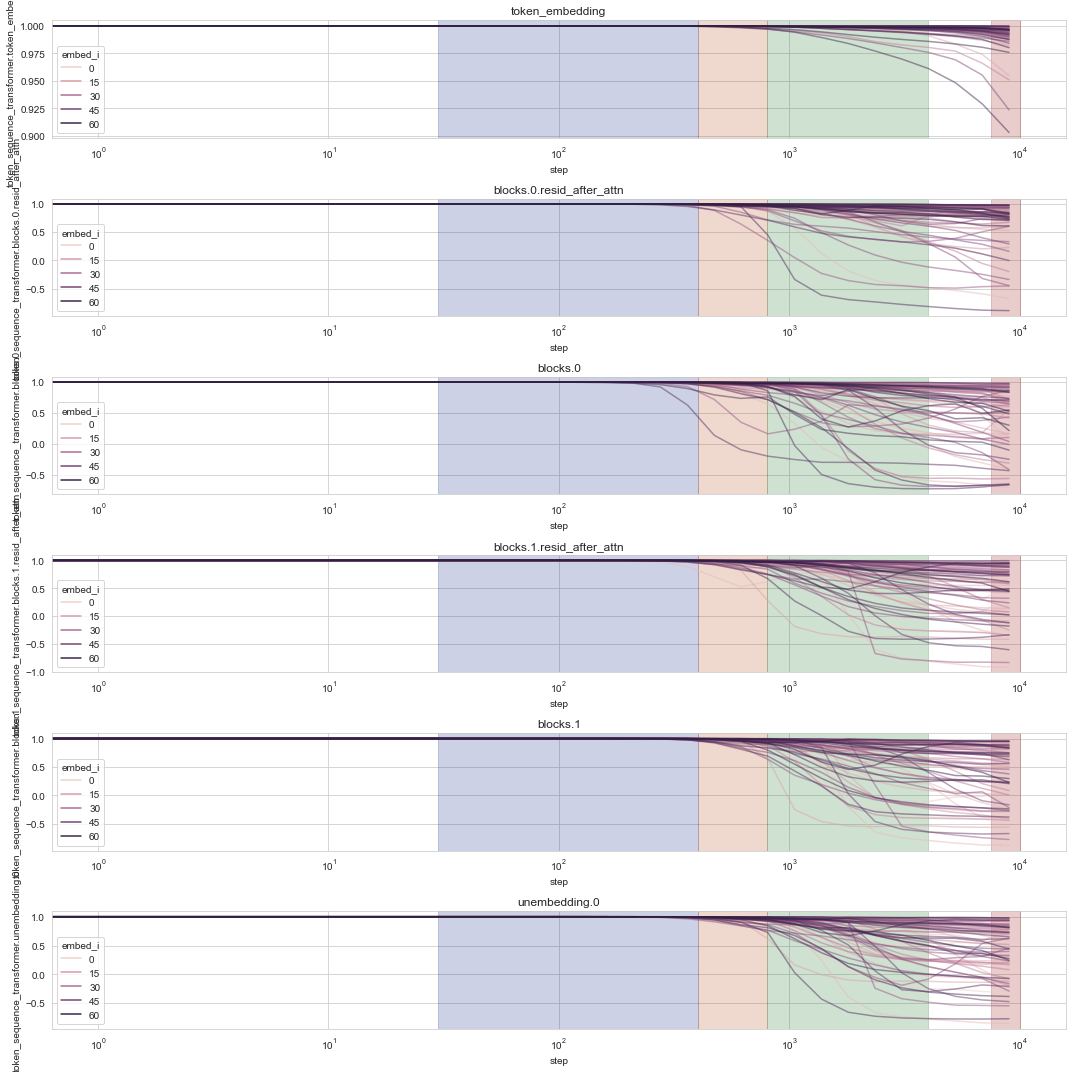

In [217]:
fig, axes = plt.subplots(len(resid_layers), 1, figsize=(15, 15))

MAX_STEP = 10_000

for layer, ax in zip(resid_layers, axes):
    sns.lineplot(data=activations.loc[activations.step < MAX_STEP], x="step", y=layer, hue="embed_i", alpha=0.5, ax=ax)
    ax.set_title(layer.replace("token_sequence_transformer.", ""))
    ax.set_xscale("log")
    
    for color, (start, end, label) in zip(milestone_colors, milestones):
        end = min(end, MAX_STEP)

        if start < MAX_STEP:
            ax.axvspan(start, end, alpha=0.2, label=label, color=color)


plt.tight_layout()
plt.show()

In [129]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def fit_transform_explained_var(model, n_components=5):
    pca = PCA(n_components=n_components)
    transforms = pca.fit_transform(model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy())
    return transforms, pca

dr_embeddings_over_time_fit = [
    fit_transform_explained_var(model, 5)
    for model in models
]

# Create a subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('3D PCA', 'Explained Variance'),
    column_widths=[0.7, 0.3],
    specs=[[{'type': 'scatter3d'}, {'type': 'bar'}]]
)


# Create frames for each PCA projection and explained variance
frames = [
    go.Frame(
        data=[
            go.Scatter3d(
            x=embed[0][:, 0], 
            y=embed[0][:, 1], 
            z=embed[0][:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
            go.Bar(
                x=list(range(1, len(embed[1].explained_variance_ratio_) + 1)),
                y=embed[1].explained_variance_ratio_,
                name="Explained Variance",
            )
        ],
        name=str(i)
    ) for i, embed in enumerate(dr_embeddings_over_time_fit)
]

# Add frames to figure
fig.frames = frames

# Add initial data
fig.add_trace(
     go.Scatter3d(
            x=dr_embeddings_over_time_fit[0][0][:, 0], 
            y=dr_embeddings_over_time_fit[0][0][:, 1], 
            z=dr_embeddings_over_time_fit[0][0][:, 2],
            mode='markers',
            marker=dict(
                    # symbol=symbols[:-2],
                    symbol="circle",
                    size=5 #sizes[:-2], 
                    # opacity=opacities[:-2]
                )
        ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=list(range(1, len(dr_embeddings_over_time_fit[0][1].explained_variance_ratio_) + 1)),
        y=dr_embeddings_over_time_fit[0][1].explained_variance_ratio_,
        name="Explained Variance",
    ),
    row=1, col=2
)

# Create slider steps
steps = [
    dict(
        args=[[frame.name], {"frame": {"duration": 100, "redraw": True},
                             "mode": "immediate",
                             "transition": {"duration": 100}}],
         label=str(step), 
              method="animate") for step, frame in zip(run.checkpointer.file_ids, frames)]


# Add slider and play button
sliders = [dict(steps=steps,
                active=0,
                yanchor='top',
                xanchor='left',
                currentvalue={
                    "font": {"size": 20},
                    "prefix": "Model:",
                    "visible": True,
                    "xanchor": "right"
                },
                transition={"duration": 300, "easing": "cubic-in-out"})]
fig.update_layout(
    updatemenus=[
        dict(type="buttons",
             showactive=False,
             buttons=[
                 dict(label="Play",
                      method="animate",
                      args=[None, {"frame": {"duration": 200, "redraw": True},
                                   "fromcurrent": True,
                                   "transition": {"duration": 200}}])
             ])
    ],
    sliders=sliders,
    yaxis1=dict(range=[0, 1])
)

fig.show()


In [ ]:
import pandas as pd
# Let's look at the 5 layer norms over time

ln_layers = [
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
    "token_sequence_transformer.unembedding.0"
]

lns_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    for layer in ln_layers:
        lns_over_time.append({
            "step": step,
            "layer": layer,
            "weight": model.state_dict()[layer + ".weight"].detach().cpu().numpy(),
            "bias": model.state_dict()[layer + ".bias"].detach().cpu().numpy()
        })

lns_over_time = pd.DataFrame(lns_over_time)

max_y_weight = {}
max_y_bias = {}
for layer in ln_layers:
    all_weights = [item for item in lns_over_time.loc[lns_over_time['layer'] == layer]['weight']]
    all_biases = [item for item in lns_over_time.loc[lns_over_time['layer'] == layer]['bias']]
    max_y_weight[layer] = max([val.max() for val in all_weights])
    max_y_bias[layer] = max([val.max() for val in all_biases])


In [ ]:
# Initialize subplots, 2 rows (for weight and bias) and 5 columns (for each layer)
fig = make_subplots(rows=2, cols=5, subplot_titles=[(".").join(ln_layer.replace("layer_norms", "ln").split('.')[1:]) + ".weight" for ln_layer in ln_layers] + [(".").join(ln_layer.replace("layer_norms", "ln").split('.')[1:]) + ".bias" for ln_layer in ln_layers])

for index, layer in enumerate(ln_layers):
    initial_data = lns_over_time[(lns_over_time['layer'] == layer) & (lns_over_time['step'] == 0)]
    
    # Weight bar plot
    fig.add_trace(
        go.Bar(x=list(range(len(initial_data['weight'].iloc[0]))), y=initial_data['weight'].iloc[0]),
        row=1, col=index+1
    )
    fig.update_yaxes(range=[0, max_y_weight[layer]], row=1, col=index+1)
    
    # Bias bar plot
    fig.add_trace(
        go.Bar(x=list(range(len(initial_data['bias'].iloc[0]))), y=initial_data['bias'].iloc[0]),
        row=2, col=index+1
    )
    fig.update_yaxes(range=[0, max_y_bias[layer]], row=2, col=index+1)

# Define animation frames
frames = []
for step in lns_over_time['step'].unique():
    frame_data = []
    
    for index, layer in enumerate(ln_layers):
        step_data = lns_over_time[(lns_over_time['layer'] == layer) & (lns_over_time['step'] == step)]
        
        # Weight
        frame_data.append(go.Bar(x=list(range(len(step_data['weight'].iloc[0]))), y=step_data['weight'].iloc[0]))
        
        # Bias
        frame_data.append(go.Bar(x=list(range(len(step_data['bias'].iloc[0]))), y=step_data['bias'].iloc[0]))
    
    frames.append(go.Frame(data=frame_data, name=f"Step {step}"))

fig.frames = frames

# Add play and pause buttons
animation_settings = dict(frame=dict(duration=300, redraw=True), fromcurrent=True)
fig.update_layout(updatemenus=[dict(type="buttons", showactive=False, buttons=[dict(label="Play",
                                            method="animate", args=[None, animation_settings]),
                                          dict(label="Pause", method="animate", args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])])])


# Add sliders
sliders = [dict(steps=[dict(method='animate', args=[[f'Step {s}'], dict(mode='immediate', frame=dict(duration=300, redraw=True))], label=f'Step {s}') for s in lns_over_time['step'].unique()], active=0)]

fig.update_layout(sliders=sliders)

# Show figure
fig.show()

[0.66135216 0.2669241  0.06167726 0.6213173 ]


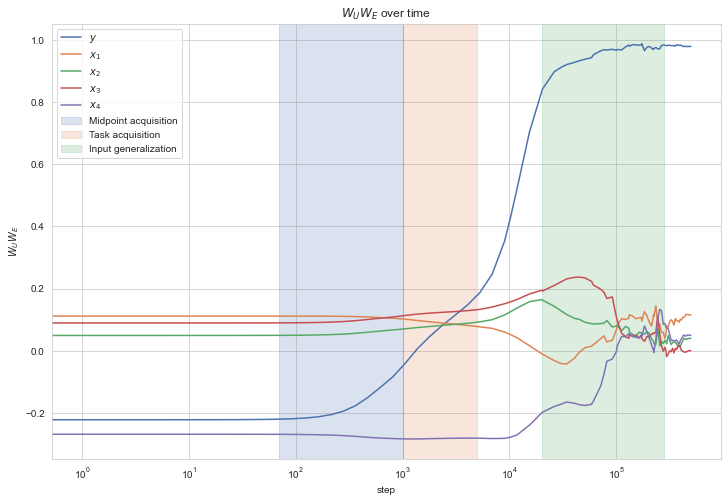

In [34]:
# I want to see if the intermediate layers are doing anything besides scaling. 
# I should check how the unembedding multiplied by the embedding (ignoring the layer norm) looks over time (measure cossim with task).
# I should look how the model ran on basis vectors performs (when you let it use the entire model)
# I should try this at different token indices to see if somehow any information is conveyed between tokens.
task = run.pretrain_dist.task_distribution.tasks[0]
task_np = task.detach().cpu().numpy()
task_embed = np.zeros(5)
task_embed[1:] = task_np
print(task_np)

embed_unembed = [
    model.token_sequence_transformer.unembedding[1].weight.detach().cpu().numpy() @ model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
    for model in models
]

cossims = [
    (v @ task_embed) / (np.linalg.norm(v) * np.linalg.norm(task_embed)) for v in embed_unembed
]


fig = plt.figure(figsize=(12, 8))
plt.plot(run.checkpointer.file_ids, cossims, label=["$y$", "$x_1$", "$x_2$", "$x_3$", "$x_4$"])
plt.xscale("log")
plt.xlabel("step")
plt.ylabel("$W_U W_E$")
plt.title("$W_U W_E$ over time")


# Milestones
for color, (start, end, label) in zip(milestone_colors, milestones):
    plt.axvspan(start, end, alpha=0.2, label=label, color=color)

# Add milestone legend
patchList = []
for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = patches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key)

fig.set_facecolor('white')


plt.legend(handles=patchList, loc='lower left')
plt.legend()

(4,) (5,)


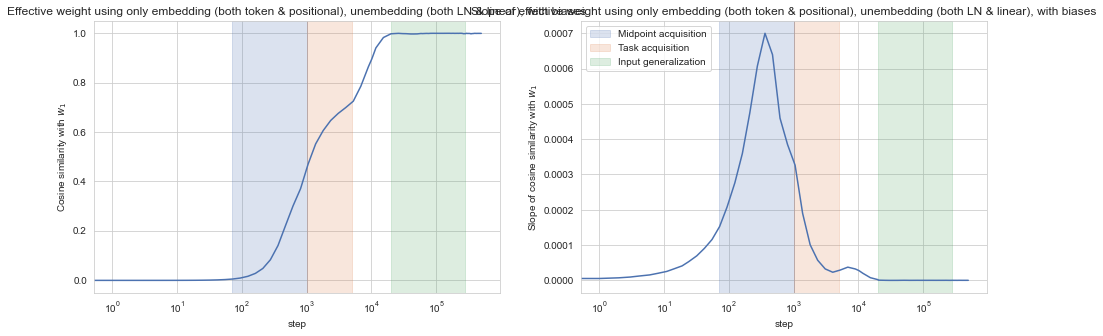

In [35]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu")
    ys = torch.zeros(1, 1, 1, device="cpu")

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np) ) for v in embed_unembed_with_bias
]

def to_slopes(steps, values):
    slope = np.zeros(len(steps))

    # Compute Slope and Curvature
    for i in range(1, len(steps) - 1):
        dx1 = steps[i+1] - steps[i]
        dx0 = steps[i] - steps[i-1]
        
        dy1 = values[i+1] - values[i]
        dy0 = values[i] - values[i-1]
        
        slope[i] = (dy1 / dx1 + dy0 / dx0) / 2

    return slope

cossims_slopes = to_slopes(run.checkpointer.file_ids, cossims)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.plot(run.checkpointer.file_ids, cossims)
ax0.set_xscale("log")
ax0.set_xlabel("step")
ax0.set_ylabel(r"Cosine similarity with $w_1$")
ax0.set_title("Effective weight using only embedding (both token & positional), unembedding (both LN & linear), with biases")

ax1.plot(run.checkpointer.file_ids, cossims_slopes)
ax1.set_xscale("log")
ax1.set_xlabel("step")
ax1.set_ylabel(r"Slope of cosine similarity with $w_1$")
ax1.set_title("Slope of effective weight using only embedding (both token & positional), unembedding (both LN & linear), with biases")

# Milestones
for ax in (ax0, ax1):
    for color, (start, end, label) in zip(milestone_colors, milestones):
        ax.axvspan(start, end, alpha=0.2, label=label, color=color)

# Add milestone legend
patchList = []
for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = patches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key)

fig.set_facecolor('white')
plt.legend(handles=patchList, loc='lower left')
plt.legend()

(4,) (5,)


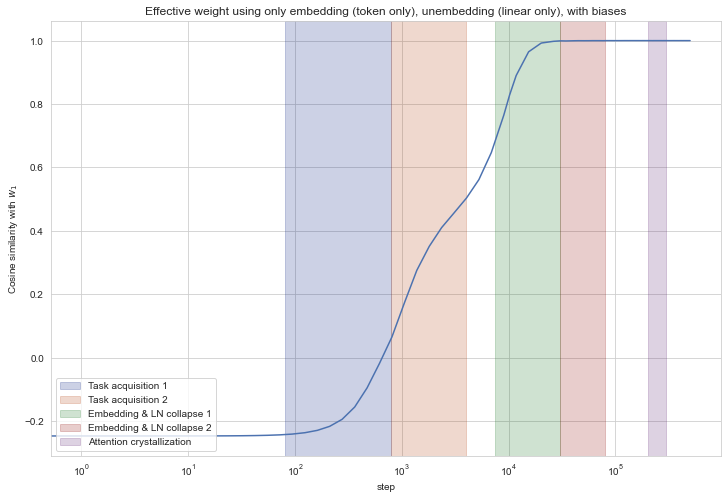

In [104]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) #+ self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        # x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu")
    ys = torch.zeros(1, 1, 1, device="cpu")

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np)) for v in embed_unembed_with_bias
]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(run.checkpointer.file_ids, cossims)
ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_ylabel(r"Cosine similarity with $w_1$")
ax.set_title("Effective weight using only embedding (token only), unembedding (linear only), with biases")

# Milestones
for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

# Add milestone legend
patchList = []
for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = patches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key) 

fig.set_facecolor('white')


plt.legend(handles=patchList, loc='lower left')

In [100]:
models_dict = dict(zip(run.checkpointer.file_ids, models))
print(models_dict.keys())

dict_keys([0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124, 162, 211, 276, 362, 473, 618, 808, 1056, 1381, 1805, 2359, 3084, 4031, 5269, 6887, 9003, 10204, 11767, 15381, 20104, 20408, 26279, 30612, 34349, 40816, 44897, 51020, 58684, 61224, 71428, 76706, 81632, 91836, 100262, 102040, 112244, 122448, 131051, 132653, 142857, 153061, 163265, 171296, 173469, 183673, 193877, 204081, 214285, 223899, 224489, 234693, 244897, 255102, 265306, 275510, 285714, 292657, 295918, 306122, 316326, 326530, 336734, 346938, 357142, 367346, 377551, 382529, 387755, 397959, 408163, 418367, 428571, 438775, 448979, 459183, 469387, 479591, 489795, 499999])


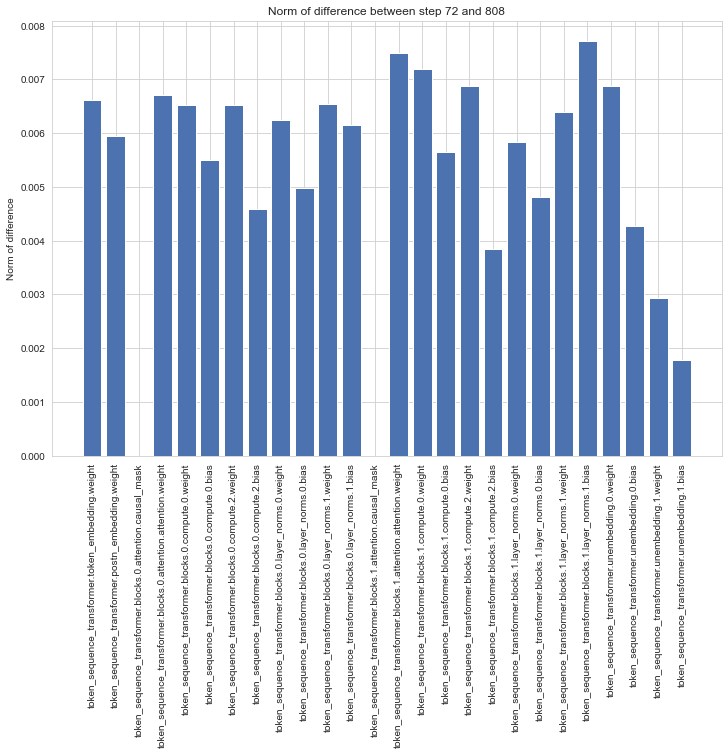

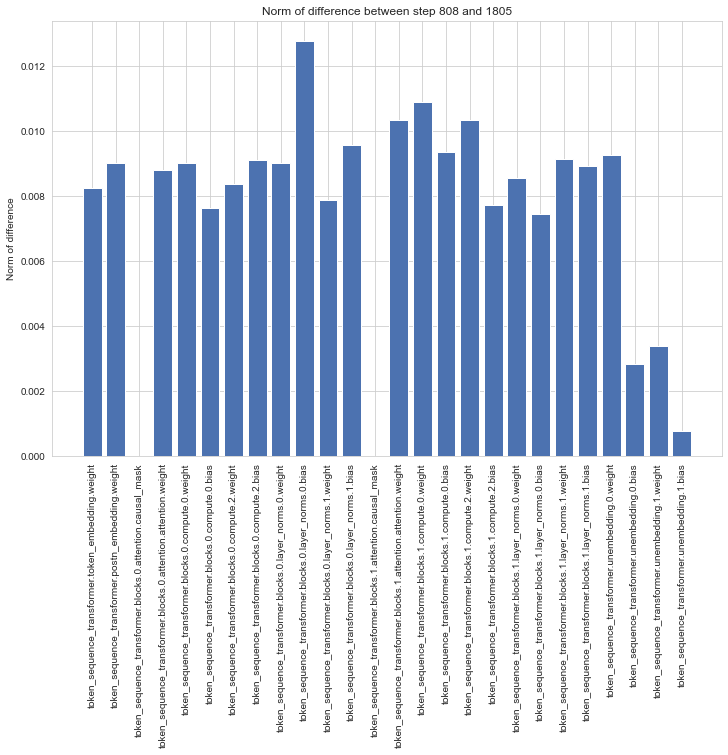

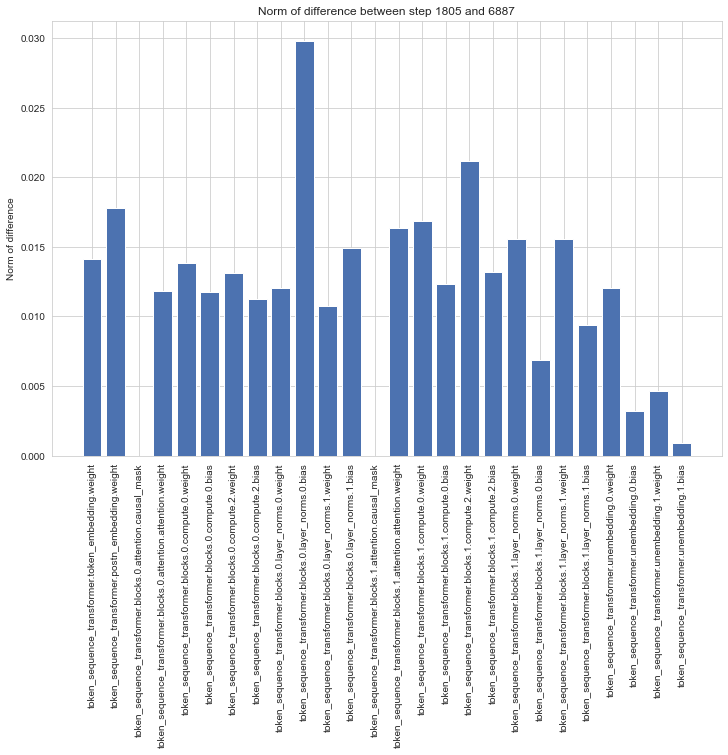

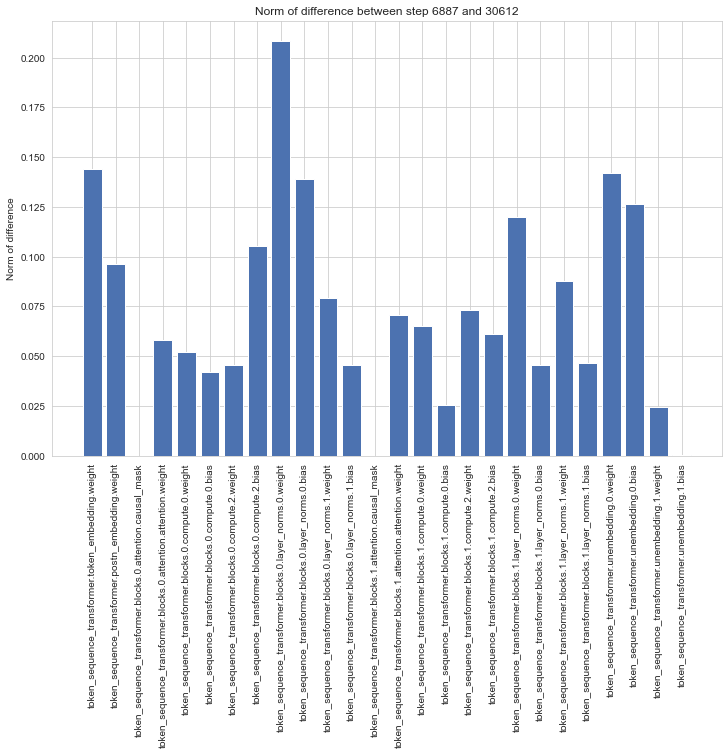

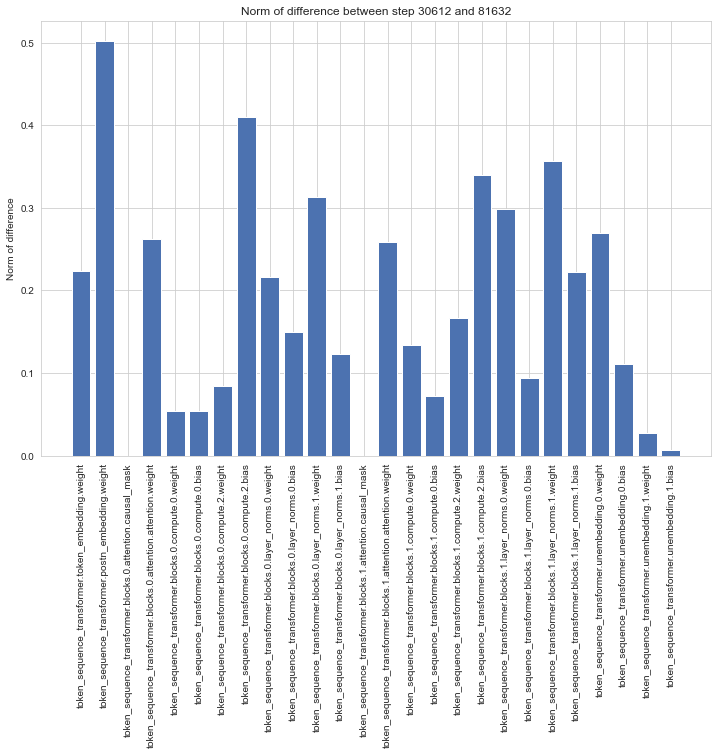

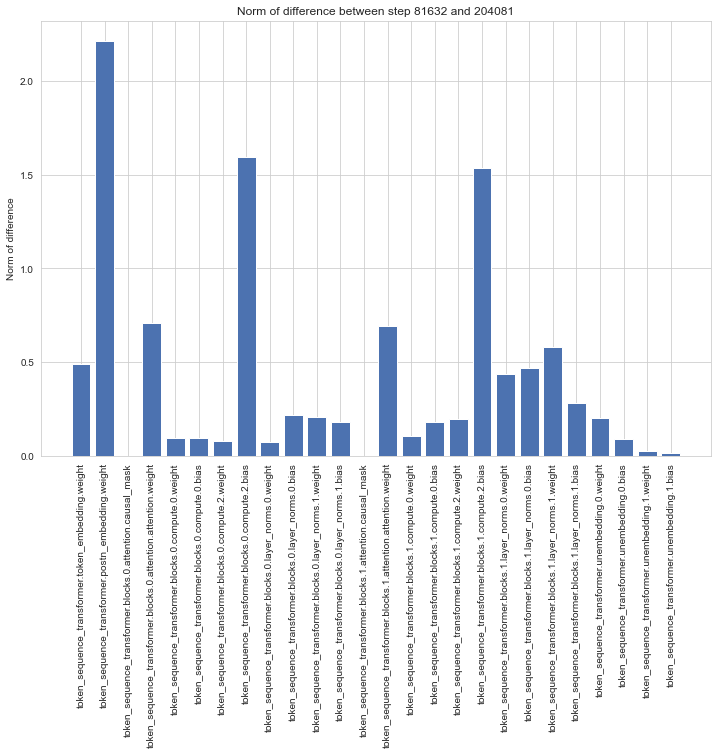

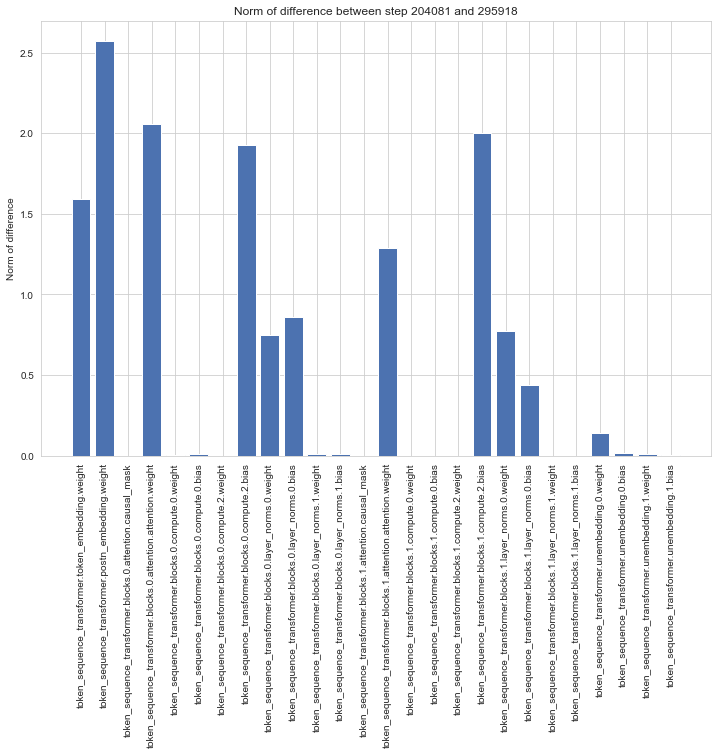

In [79]:
def get_diff_norm(step1, step2):
    model1 = models_dict[step1]
    model2 = models_dict[step2]
    diffs = {}
    for key in model1.state_dict().keys():
        diffs[key] = (model1.state_dict()[key] - model2.state_dict()[key]).std().item() # / model1.state_dict()[key].norm().item() #  model1.state_dict()[key].numel()

    return diffs


def get_closest_step(step):
    return min(models_dict.keys(), key=lambda x: abs(int(x) - step))

milestone_steps = sorted(list({m for milestone in milestones for m in milestone[:2]}))
milestone_steps = [get_closest_step(m) for m in milestone_steps]

for m1, m2 in zip(milestone_steps, milestone_steps[1:]):
    diffs = get_diff_norm(m1, m2)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.bar(np.arange(len(diffs)), list(diffs.values()))
    ax.set_xticks(np.arange(len(diffs)), list(diffs.keys()), rotation=90)
    ax.set_ylabel("Norm of difference")
    ax.set_title(f"Norm of difference between step {m1} and {m2}")

    fig.set_facecolor('white')

    plt.show()

In [76]:
# It makes perfect sense that the layer norm biases are changing most from this perspective because they start at 0

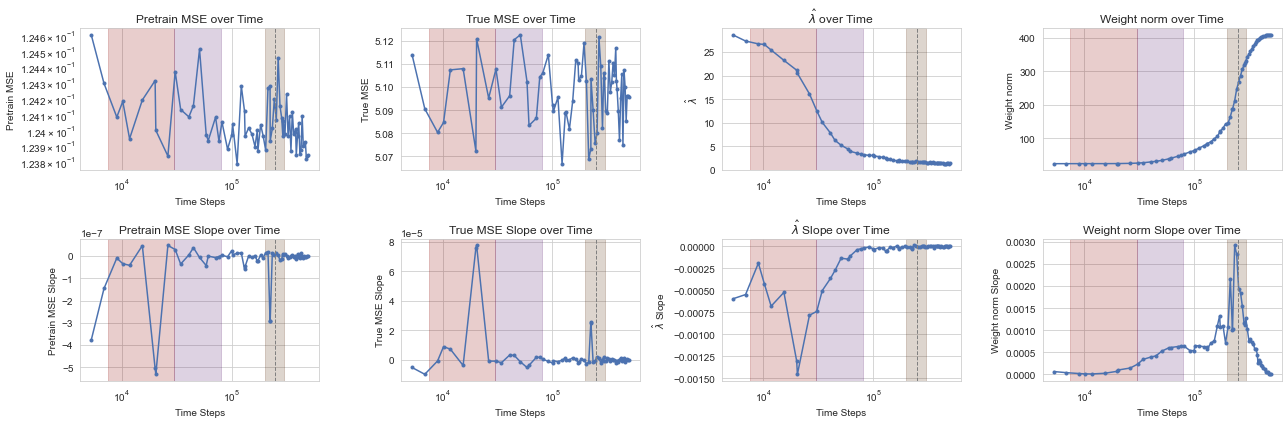

In [122]:
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(18, 6))

START_STEP_INDEX = 30

for i, (metric_name, metric_values, kwargs) in enumerate(metrics_to_plot):
    axes[0, i].plot(run.checkpointer.file_ids[START_STEP_INDEX:], metric_values[START_STEP_INDEX:], label=metric_name, marker='.')
    axes[0, i].set_title(metric_name + " over Time")
    axes[0, i].set_xlabel('Time Steps')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[1, i].plot(run.checkpointer.file_ids[START_STEP_INDEX:], metric_slopes[i][START_STEP_INDEX:], label=metric_name + " Slope", marker='.')
    axes[1, i].set_title(metric_name + " Slope over Time")
    axes[1, i].set_xlabel('Time Steps')
    axes[1, i].set_ylabel(metric_name + " Slope")

    # Plot vertical line at 250k steps
    axes[0, i].axvline(x=250000, color="grey", linestyle="--", linewidth=1)
    axes[1, i].axvline(x=250000, color="grey", linestyle="--", linewidth=1)

first_step = run.checkpointer.file_ids[START_STEP_INDEX]

for ax in axes.flatten():
    for color, (start, end, label) in zip(milestone_colors, milestones):
        if end < first_step:
            continue

        ax.axvspan(max(start, first_step), end, alpha=0.2, label=label, color=color)
        ax.set_xscale('log')
    
    # ax.set_xscale('log')

fig.set_facecolor("white")
fig.tight_layout()

In [ ]:
# What's happening at the start? 
# I think the model is learning something like linear regression (using the unembedding) on mostly random features (due to the attention & MLPs).
# The randomness has a regularlizing effect.
# By 5000 steps, the model has ~perfect performance. If we throw out the attention and MLP and positional encoding, this performance is reduced.
# When we find this solution, the model then starts trying to reduce its dependence on the MLP and attention. 
# By 10k steps, the model only needs the embedding/unembedding to actually solve the task. However, the LN continues to have a regularizing effect akin to dropout or random noise applied to logits.
# To get around this, the model starts increasing the scale of its activations. To accomplish this while maintaining a zero mean, the embedding collapses in rank. 

In [59]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations

DEVICE = "mps"

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.true_seed)


# shorthands
B = 1024
K = 8
D = 4

# sample a batch of random tasks
ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(B, K, D,),
    device=DEVICE
)
xs100 = 100 * xs
ys = apply_transformations(ws, xs, 0, DEVICE)
ys100 = apply_transformations(ws, xs100, 0, DEVICE)

def eval_loss(model, xs, ys):
    return torch.nn.functional.mse_loss(
        model(xs, ys),
        ys,
    ).mean()

In [62]:
losses_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    model.to('mps')
    losses_over_time.append({
        "step": step,
        "loss": eval_loss(model, xs, ys).item(),
        "loss100": eval_loss(model, xs100, ys100).item()
    })

losses_over_time = pd.DataFrame(losses_over_time)

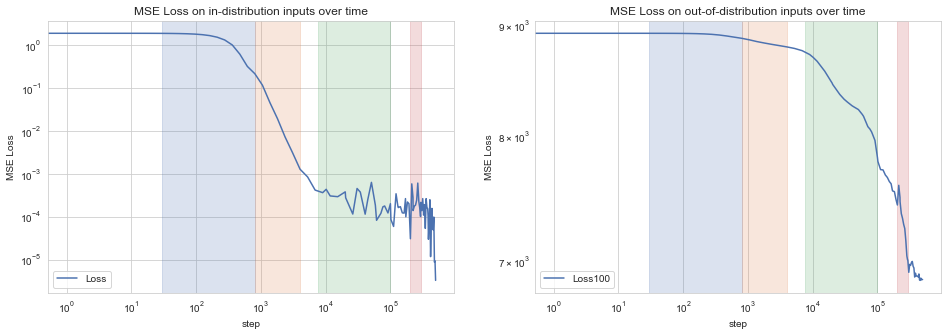

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.lineplot(data=losses_over_time, x="step", y="loss", label="Loss", ax=axes[0])
sns.lineplot(data=losses_over_time, x="step", y="loss100", label="Loss100", ax=axes[1])

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("step")
    ax.set_yscale('log')
    ax.set_ylabel("MSE Loss")

axes[0].set_title("MSE Loss on in-distribution inputs over time")
axes[1].set_title("MSE Loss on out-of-distribution inputs over time")

for ax in axes.flatten():
    for color, (start, end, label) in zip(milestone_colors, milestones):
        ax.axvspan(start, end, alpha=0.2, label=label, color=color)
    
    ax.set_xscale('log')

# Add milestone legend
patchList = []

for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = mpatches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key)

fig.set_facecolor('white')

In [271]:
def eval_output_magnitude(model, xs, ys):
    norms = model(xs, ys).squeeze(-1).norm(dim=-1)
    # norms = model(xs, ys).squeeze(-1).abs().mean(dim=-1)
    return norms.mean().item(), norms.std().item()

output_magnitudes_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    norm, norm_std = eval_output_magnitude(model, xs, ys)
    output_magnitudes_over_time.append({
        "step": step,
        "output_magnitude": norm,
        "output_magnitude_std": norm_std
    })

output_magnitudes_over_time = pd.DataFrame(output_magnitudes_over_time)

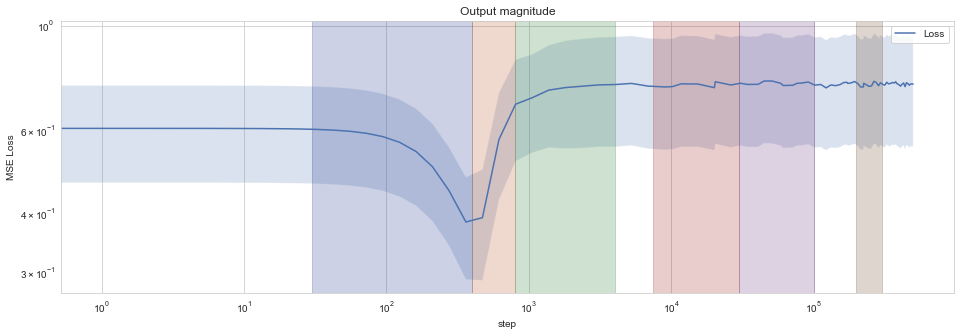

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.lineplot(data=output_magnitudes_over_time, x="step", y="output_magnitude", label="Loss", ax=ax)

ax.fill_between(
    output_magnitudes_over_time["step"],
    output_magnitudes_over_time["output_magnitude"] - output_magnitudes_over_time["output_magnitude_std"],
    output_magnitudes_over_time["output_magnitude"] + output_magnitudes_over_time["output_magnitude_std"],
    alpha=0.2
)

ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_yscale('log')
ax.set_ylabel("MSE Loss")

ax.set_title("Output magnitude")

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

ax.set_xscale('log')

# Add milestone legend
patchList = []

fig.set_facecolor('white')

In [296]:
# Let's see how this compares to the learning curve if we train models to predict 0
from collections import defaultdict
from devinfra.io.logging import DataFrameLogger
from torch.nn import functional as F
from tqdm import trange
import yaml 

# model_trained_0s = deepcopy(models[0]) 
model_trained_normal = deepcopy(models[0]) 

# gradients = []
# logs = defaultdict(dict)

log_steps = sorted(list(run.config.logger_config.logging_steps))

for i, model in [(1, model_trained_normal)]:
# for i, model in enumerate([model_trained_0s, model_trained_normal]):
    optimizer = run.config.optimizer_config.factory(model.parameters())
    scheduler = run.config.scheduler_config.factory(optimizer)
    num_steps = 5000

    batch_losses = np.zeros(num_steps)


    # training loop
    for step in trange(num_steps, desc="Training..."):
        set_seed(
            run.config.task_config.sampling_seed + step
        )  # For reproducibility if we resume training

        # data generation and forward pass
        xs, ys = run.pretrain_dist.get_batch(
            num_examples=run.config.task_config.max_examples,
            batch_size=run.config.batch_size,
        )

        ys_pred = model(xs, ys)
        target_ys = torch.zeros_like(ys) if i == 0 else ys

        loss = F.mse_loss(target_ys, ys_pred)
        # backward pass and gradient step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 100 == 0:
            batch_losses[step] = loss.mean().item()

        # Log to wandb & save checkpoints according to log_steps
        if step in run.config.logger_config.logging_steps:
            log_idx = log_steps.index(step)

            model.eval()
            magnitudes = eval_output_magnitude(model, xs, ys)
            metrics = {
                f"loss/{i}": eval_loss(model, xs, ys).item(),
                f"magnitudes/{i}": magnitudes[0],
                f"magnitudes_std/{i}": magnitudes[1],
            }
            if i == 0:
                gradients.append([p.data for p in model.parameters()])
            else:
                # norm0 = sum([p.norm() ** 2 for p in gradients[log_idx]]) ** 0.5
                # norm1 = sum([p.norm() ** 2 for p in model.parameters()]) ** 0.5
                # dot = sum([(p1 * p2.data).sum() for p1, p2 in zip(gradients[log_idx], model.parameters())])
                norms0 = ([p.norm() ** 2 for p in gradients[log_idx]])
                norms1 = ([p.norm() ** 2 for p in model.parameters()])
                dots = ([(p1 * p2.data).sum() for p1, p2 in zip(gradients[log_idx], model.parameters())])
                grad_cossims = dot / (norm0 * norm1)

                metrics["cossim"] = grad_cossims.item()

            logs[step].update(metrics)

            model.train()
            # print(yaml.dump(metrics))

Training...: 100%|██████████| 5000/5000 [02:03<00:00, 40.33it/s]


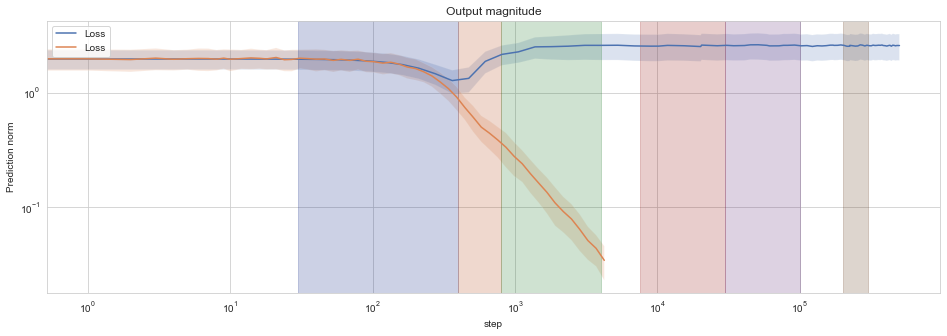

In [290]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.lineplot(data=output_magnitudes_over_time, x="step", y="output_magnitude", label="Loss", ax=ax)

ax.fill_between(
    output_magnitudes_over_time["step"],
    output_magnitudes_over_time["output_magnitude"] - output_magnitudes_over_time["output_magnitude_std"],
    output_magnitudes_over_time["output_magnitude"] + output_magnitudes_over_time["output_magnitude_std"],
    alpha=0.2
)

sns.lineplot(data=df_trained_to_0, x="step", y="magnitudes", label="Loss", ax=ax)

ax.fill_between(
    df_trained_to_0["step"],
    df_trained_to_0["magnitudes"] - df_trained_to_0["magnitudes_std"],
    df_trained_to_0["magnitudes"] + df_trained_to_0["magnitudes_std"],
    alpha=0.2
)

ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_yscale('log')
ax.set_ylabel("Prediction norm")

ax.set_title("Output magnitude")

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

ax.set_xscale('log')

# Add milestone legend
patchList = []

fig.set_facecolor('white')
plt.savefig("../figures/L2H4M1-output_magnitude.png")

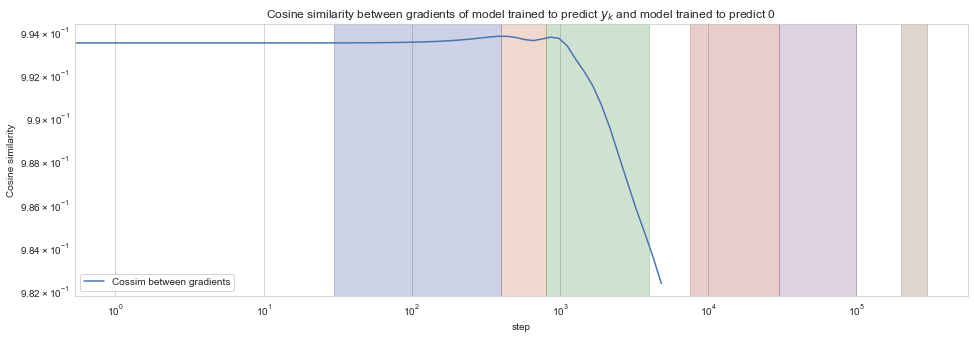

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

sns.lineplot(data=logs_df, x="step", y="cossim", label="Cossim between gradients", ax=ax)

ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_yscale('log')
ax.set_ylabel("Cosine similarity")

ax.set_title("Cosine similarity between gradients of model trained to predict $y_k$ and model trained to predict 0")

for color, (start, end, label) in zip(milestone_colors, milestones):
    ax.axvspan(start, end, alpha=0.2, label=label, color=color)

ax.set_xscale('log')

# Add milestone legend
patchList = []

fig.set_facecolor('white')
plt.savefig("../figures/L2H4M1-output_magnitude.png")

In [301]:
logs_df.cossim = [cs.item() for cs in logs_df.cossim]
logs_df

step    loss/0  magnitudes/0  magnitudes_std/0    loss/1  magnitudes/1  \
0      0  2.130095      1.994894          0.395624  2.130092      1.994898   
1      1  2.029752      1.975601          0.415527  2.029743      1.975613   
2      2  2.078827      1.946669          0.426553  2.078805      1.946690   
3      3  2.194622      2.004123          0.431340  2.194589      2.004159   
4      4  2.019861      1.958577          0.394620  2.019813      1.958636   
5      5  2.015114      1.981512          0.393218  2.015046      1.981589   
6      6  2.065548      1.991986          0.440468  2.065450      1.992095   
7      7  2.064530      1.986640          0.442741  2.064418      1.986775   
8      8  2.066823      1.962517          0.397156  2.066665      1.962691   
9      9  2.182893      2.003195          0.388506  2.182736      2.003407   
10    10  2.057424      1.960498          0.422408  2.057203      1.960740   
11    12  1.997061      1.987470          0.374617  1.996832      1.987825   
12    14  2.065069      2.012738          0.411955  2.064734      2.013245   
13    16  2.018607      1.997621          0.379809  2.018168      1.998286   
14    18  2.019131      1.973888          0.379802  2.018523      1.974590   
15    21  2.113408      2.030609          0.431548  2.112689      2.031544   
16    24  1.994768      1.941635          0.399421  1.993720      1.942819   
17    27  2.024534      1.952733          0.414765  2.023244      1.954312   
18    31  2.063519      2.001184          0.373448  2.061765      2.003201   
19    35  2.135319      1.985784          0.394267  2.133132      1.988341   
20    40  2.020433      1.963071          0.427538  2.017581      1.966588   
21    46  2.039688      1.969672          0.397428  2.035925      1.974121   
22    53  1.936310      1.914955          0.397843  1.931218      1.921445   
23    60  2.029453      1.956371          0.389818  2.023175      1.964472   
24    69  1.992442      1.915033          0.397755  1.984692      1.926039   
25    79  2.069607      1.961649          0.368594  2.059052      1.976972   
26    90  1.876073      1.882760          0.371966  1.863102      1.898801   
27   103  1.886299      1.863343          0.365033  1.869084      1.884371   
28   118  1.860034      1.812628          0.366776  1.837008      1.836477   
29   134  1.992494      1.845000          0.372090  1.960684      1.877396   
30   153  1.922086      1.777605          0.353493  1.877744      1.816910   
31   175  1.835665      1.676292          0.345015  1.778732      1.728760   
32   200  1.748058      1.624768          0.336420  1.675617      1.694244   
33   229  1.647925      1.521384          0.288286  1.549850      1.615815   
34   261  1.635659      1.399589          0.271245  1.503067      1.522579   
35   298  1.580118      1.241651          0.259508  1.401261      1.390565   
36   341  1.491148      1.084210          0.237911  1.249150      1.326634   
37   389  1.362788      0.915481          0.210843  1.046561      1.248061   
38   444  1.227357      0.742640          0.162745  0.816723      1.275278   
39   507  1.262699      0.612348          0.155556  0.700445      1.409054   
40   579  1.085091      0.500473          0.127705  0.472519      1.815877   
41   661  1.126511      0.443212          0.124287  0.432391      2.029000   
42   755  1.049897      0.387044          0.115187  0.369753      2.150634   
43   862  1.103148      0.334360          0.111196  0.336515      2.239453   
44   984  1.059512      0.278563          0.091632  0.275819      2.273520   
45  1124  1.053100      0.239408          0.073478  0.227998      2.329205   
46  1283  1.015721      0.195914          0.062899  0.176198      2.412039   
47  1465  1.051368      0.162459          0.052945  0.167905      2.526500   
48  1673  0.987488      0.135046          0.046831  0.146468      2.497558   
49  1910  1.004091      0.109019          0.040129  0.143309      2.522552   
50  2181  1.019705      0.

In [13]:
from devinfra.utils.seed import set_seed

DEVICE = 'mps'

# Gonna override activations sorry.
losses_over_time = []
outputs_over_time = []
activations_over_time = []

train_xs_noise, train_ys_noise = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.true_seed)

train_xs, train_ys = pretrain_dist_noiseless.get_batch(8, 1024)

assert torch.allclose(train_xs, train_xs_noise)


for model in models:
    hooked_model = hook(model)
    output, activation = hooked_model.run_with_cache(train_xs, train_ys)
    outputs_over_time.append(output)
    losses_over_time.append(nn.MSELoss()(output, train_ys).item())
    activations_over_time.append(activation)


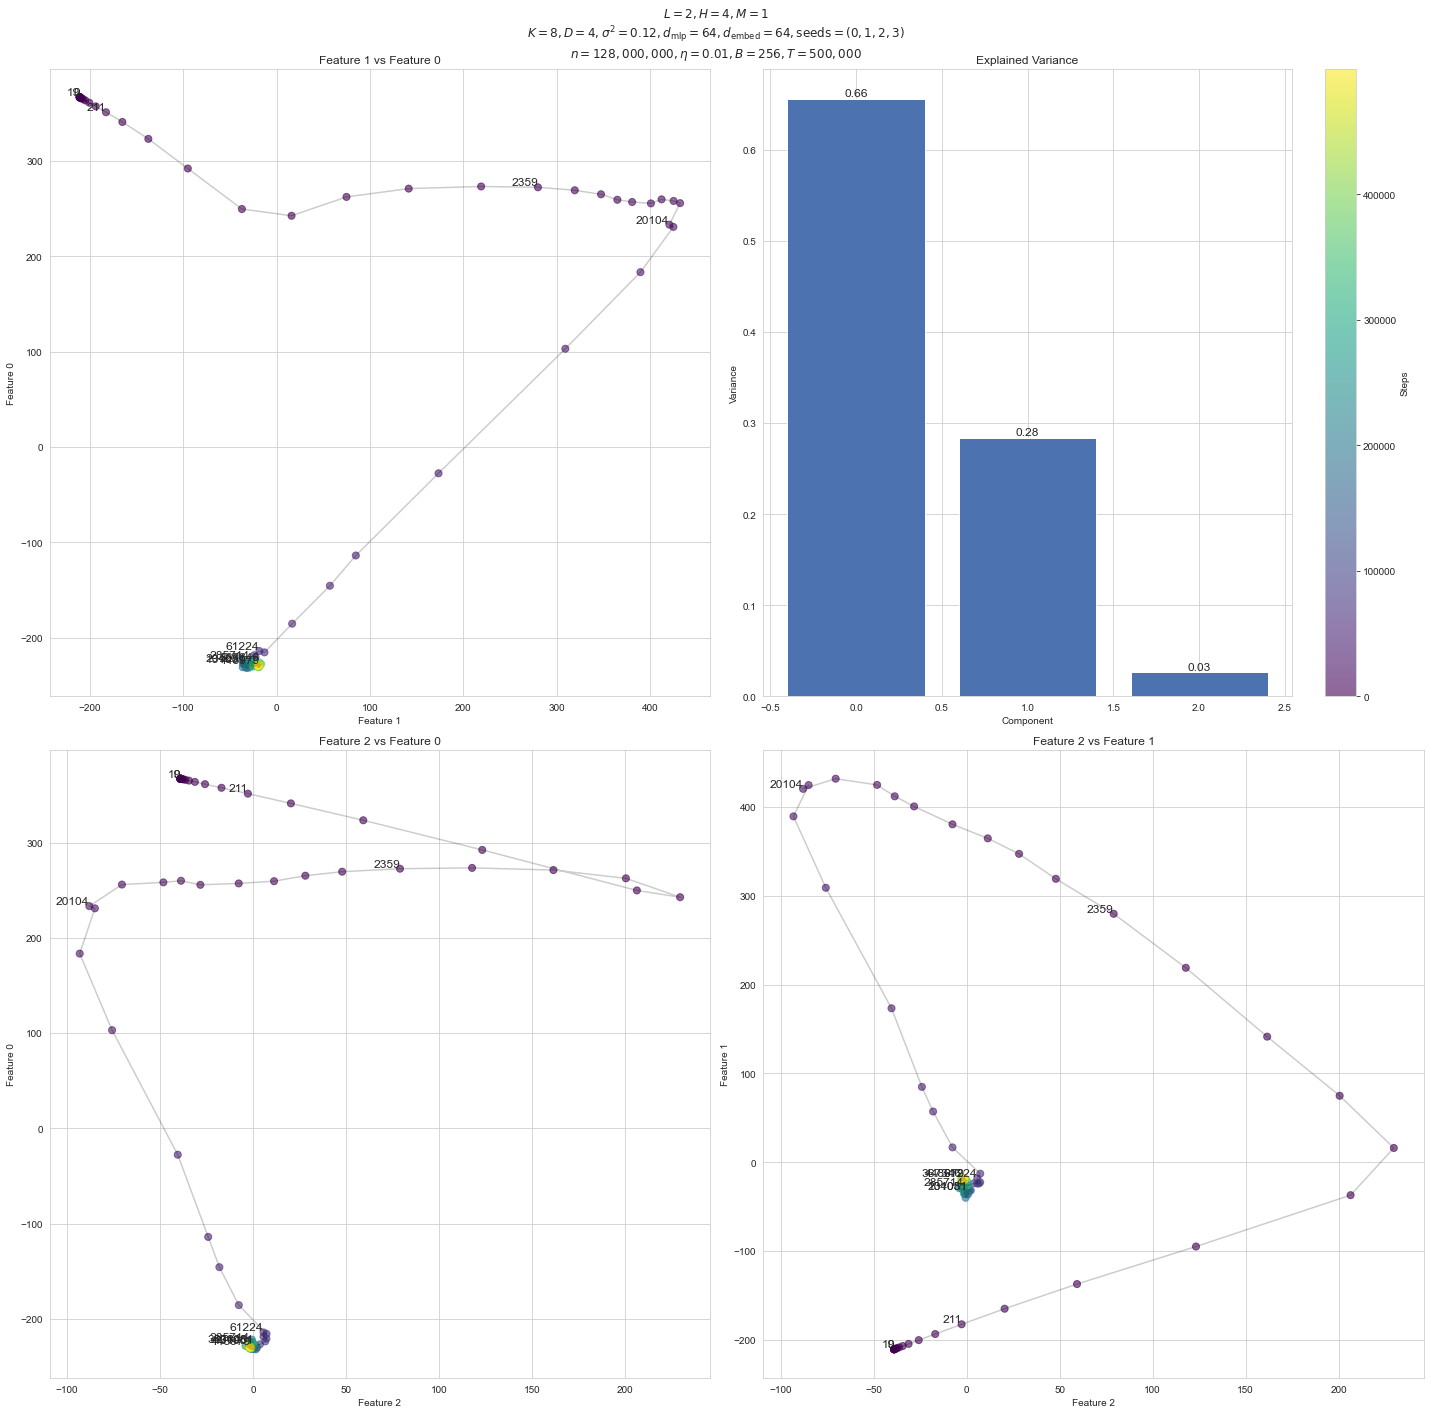

In [14]:
# Do the PCAs again. 

from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        hooked_model = hook(model, *paths)
        return {k: convert_tensor(v, return_type) for k, v in hooked_model.run_with_cache(xs, ys)[1].items() if k in paths and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results

from typing import Optional

def plot_sample_evolution(steps, samples, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Main plot
    sc = ax.scatter(samples[:, 0], samples[:, 1], c=steps, cmap='viridis', s=50, alpha=0.6)

    if connect_dots:
        ax.plot(samples[:, 0], samples[:, 1], c='black', alpha=0.2)

    plt.colorbar(sc, ax=ax, label='Steps')
    
    # Label some points
    total_samples = len(samples)
    step = total_samples // num_points_to_label
    for i in range(0, total_samples, step):
        sample_step = steps[i]
        ax.text(samples[i, 0], samples[i, 1], str(sample_step), fontsize=12, ha='right', va='bottom')
        
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)


def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Component')
    ax.set_ylabel('Variance')


def plot_sample_evolution_with_inset(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    plot_sample_evolution(steps, samples, title=title, num_points_to_label=num_points_to_label, ax=ax, connect_dots=connect_dots)

    axins = ax.inset_axes([0.7, 0.05, 0.25, 0.25])  # x, y, width, height
    axins.patch.set_alpha(0.5)
    plot_explained_variance(pca, ax=axins)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

    
def plot_multiple_slices(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    num_pca_components = samples.shape[-1]
    num_rows = num_pca_components - 1
    fig, ax = plt.subplots(num_rows, num_rows, figsize=(20, 20))

    fig.suptitle(title)

    for i in range(num_pca_components):
        for j in range(i):
            sc = ax[i-1, j].scatter(samples[:, i], samples[:, j], c=steps, cmap='viridis', s=50, alpha=0.6)
            ax[i-1, j].set_xlabel(f'Feature {i}')
            ax[i-1, j].set_ylabel(f'Feature {j}')
            ax[i-1, j].set_title(f'Feature {i} vs Feature {j}')

            if connect_dots:
                ax[i-1, j].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # Label some points
            total_samples = len(samples)
            step = total_samples // num_points_to_label
            for k in range(0, total_samples, step):
                sample_step = steps[k]
                ax[i-1, j].text(samples[k, i], samples[k, j], str(sample_step), fontsize=12, ha='right', va='bottom')

        for j in range(i + 1, num_rows):
            ax[i, j].axis('off')


    ax[0, -1].axis('on')
    plot_explained_variance(pca, ax=ax[0, -1])

    plt.colorbar(sc, ax=ax[0, -1], label='Steps')
    plt.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)
train_xs_1, train_ys_1 = pretrain_dist_noiseless.get_batch(8, 8196)


pca, logits_reduced = get_pca_activations_trace(
    models,
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    num_components=3
)['token_sequence_transformer']

plot_multiple_slices(
    steps, 
    logits_reduced, 
    pca, 
    connect_dots=True, 
    title=run.config.to_latex(), 
    save=None
)

In [41]:
# Assuming `logits_reduced` is your PCA-transformed data with shape (N, 3)
# and `steps` is a list of time steps corresponding to each frame

# Compute the intervals as the log of the step size
log_intervals = np.diff(np.log([s + 1 for s in steps]))

# Normalize the intervals to get the number of frames to stay at each point
og_frame_intervals = log_intervals / (log_intervals.min() * 2)
frame_intervals = np.array([min(ivl, 10) for ivl in og_frame_intervals])

# Create a list of indices where each point index is repeated according to its interval
frame_sequence = []
logits_interpolated = []
embeddings_interpolated = []
steps_interpolated = []

for i, interval in enumerate(frame_intervals.astype(int)):
    frame_sequence.extend([i] * interval)

    for j in range(interval):
        logits_interpolated.append(
            logits_reduced[i] + (logits_reduced[i + 1] - logits_reduced[i]) * (j + 1) / interval
        )
        embeddings_interpolated.append(
            embeddings_reduced[i] + (embeddings_reduced[i + 1] - embeddings_reduced[i]) * (j + 1) / interval
        )
        steps_interpolated.append(
            steps[i] + (steps[i + 1] - steps[i]) * (j + 1) / interval
        )

logits_interpolated = np.array(logits_interpolated)
embeddings_interpolated = np.array(embeddings_interpolated)
steps_interpolated = np.array(steps_interpolated)

print(steps)
print(frame_intervals)
print(len(logits_interpolated))
print(sum(frame_intervals.astype(int)))

0          0
1          1
2          2
3          3
4          4
       ...  
91    459183
92    469387
93    479591
94    489795
95    499999
Name: _step, Length: 96, dtype: int64
[10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
  2.8513483  10.         10.         10.         10.         10.
 10.         10.          8.05039042 10.         10.         10.
 10.         10.          3.33973594 10.         10.         10.
  2.30845548 10.         10.         10.          9.12323397  2.39504373
 10.         10.          9.74540497  9.26983044  8.33852015  0.5
  8.44556806  8.08607427  7.75668422  7.45167907  7.17041869  6.90962042
  4.56177308  2.105356

<ipython-input-47-2981bca7c594>:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point3d.set_data(logits_interpolated[num, 0], logits_interpolated[num, 1])


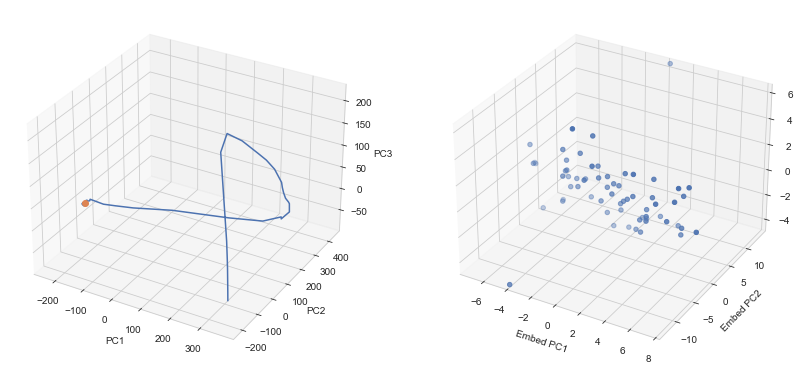

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import torch  # Ensure that PyTorch is installed

PRIMARY, SECONDARY, TERTIARY = sns.color_palette()[:3]

# Create figure and axes
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Set labels for axes
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

ax2.set_xlabel('Embed PC1')
ax2.set_ylabel('Embed PC2')
ax2.set_zlabel('Embed PC3')

ax2.set_xlim(embeddings_interpolated[:, :, 0].min(), embeddings_interpolated[:, :, 0].max())
ax2.set_ylim(embeddings_interpolated[:, :, 1].min(), embeddings_interpolated[:, :, 1].max())
ax2.set_zlim(embeddings_interpolated[:, :, 2].min(), embeddings_interpolated[:, :, 2].max())

# Initial plots
scat3d = ax1.plot(logits_interpolated[:, 0], logits_interpolated[:, 1], logits_interpolated[:, 2], color=PRIMARY)[0]
point3d, = ax1.plot([logits_interpolated[0, 0]], [logits_interpolated[0, 1]], [logits_interpolated[0, 2]], color=SECONDARY, marker="o")

scat3dembed = ax2.scatter(embeddings_interpolated[0, :, 0], embeddings_interpolated[0, :, 1], embeddings_interpolated[0, :, 2], color=PRIMARY)


# Animation update function
def update(num):
    # Update 3D scatter plot
    point3d.set_data(logits_interpolated[num, 0], logits_interpolated[num, 1])
    point3d.set_3d_properties(logits_interpolated[num, 2])

    scat3dembed._offsets3d = (embeddings_interpolated[num, :, 0],
                              embeddings_interpolated[num, :, 1],
                              embeddings_interpolated[num, :, 2])

    return point3d, scat3dembed

# Creating the animation
ani = FuncAnimation(fig, update, frames=len(frame_sequence), interval=25, blit=False)
ani.save('../figures/M1_combined_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()


In [54]:
milestones = [
    (30, 800, 'Task acquisition 1'),
    (800, 4000, 'Task acquisition 2'),
    # (800, 4000, 'Task acquisition 3'),
    (7500, 100_000, 'Embedding & LN collapse 1'),
   #(30_000, 100_000, 'Embedding & LN collapse 2'),
    (200_000, 300_000, 'Attention crystallization')
]

milestone_colors = sns.color_palette("dark", len(milestones))

Step 60.10:  18%|█▊        | 136/751 [02:29<11:15,  1.10s/it]
<ipython-input-55-73629f442e12>:82: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cursor.set_xdata(step)
<ipython-input-55-73629f442e12>:82: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cursor.set_xdata(step)


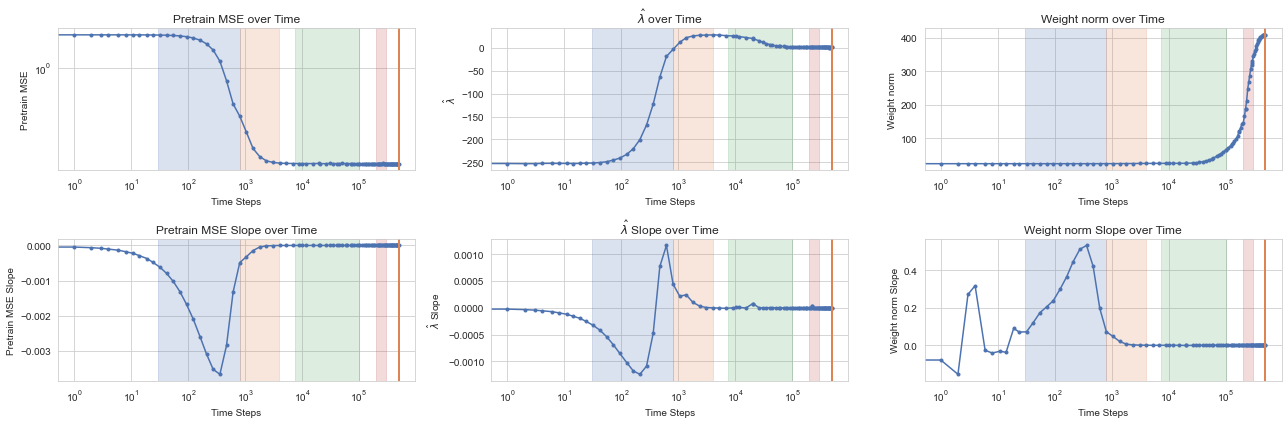

In [55]:
from matplotlib.animation import FuncAnimation


metrics_to_plot = [
    ("Pretrain MSE", evals_over_time_df["pretrain/mse"], {"logy": True}),
    # ("True MSE", evals_over_time_df["true/mse"], {"logy": False}),
    ("$\hat \lambda$", llcs, {}),
    ("Weight norm", weight_norms, {}),
] 

milestone_colors = sns.color_palette("deep", len(milestones))

# Create subplots
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(18, 6))

START_STEP_INDEX = 0
time_steps = run.checkpointer.file_ids[START_STEP_INDEX:]
first_step = time_steps[0]
end_step = time_steps[-1]

# Create the plots
for i, (metric_name, metric_values, kwargs) in enumerate(metrics_to_plot):
    axes[0, i].plot(run.checkpointer.file_ids[START_STEP_INDEX:], metric_values[START_STEP_INDEX:], label=metric_name, marker='.')
    axes[0, i].set_title(metric_name + " over Time")
    axes[0, i].set_xlabel('Time Steps')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[1, i].plot(run.checkpointer.file_ids[START_STEP_INDEX:], metric_slopes[i][START_STEP_INDEX:], label=metric_name + " Slope", marker='.')
    axes[1, i].set_title(metric_name + " Slope over Time")
    axes[1, i].set_xlabel('Time Steps')
    axes[1, i].set_ylabel(metric_name + " Slope")

    # Plot vertical line at 250k steps
    axes[0, i].axvline(x=0, color="grey", linestyle="--", linewidth=1)
    axes[1, i].axvline(x=0, color="grey", linestyle="--", linewidth=1)


# Create inset axes
# axins = axes[1, 1].inset_axes([0.7, 0.15, 0.25, 0.25])  # x, y, width, height
# axins.plot(run.checkpointer.file_ids[30:], metric_slopes[1][30:], label=metric_name + " Slope", marker='.')

all_axes = [*axes.flatten()] # axins]

for ax in axes.flatten():
    for color, (start, end, label) in zip(milestone_colors, milestones):
        ax.axvspan(start, end, alpha=0.2, label=label, color=color)

for ax in all_axes:
    ax.set_xscale('log')

# for color, (start, end, label) in zip(milestone_colors[2:], milestones[2:]):
#     ax.axvspan(start, end, alpha=0.2, label=label, color=color)

# Add milestone legend
patchList = []

for color, (start, end, label) in zip(milestone_colors, milestones):
    data_key = mpatches.Patch(color=color, alpha=0.2, label=label)
    patchList.append(data_key)

# Create a line object on each subplot for the cursor
cursors = [ax.axvline(x=first_step, color=SECONDARY, linewidth=2) for ax in axes.flatten()]

# cursors.append(
#     axins.axvline(x=first_step, color=SECONDARY, linewidth=2)
# )

total_frames = len(frame_sequence)
frame_multiplier = np.log(500_000) / total_frames

pbar = tqdm(total=total_frames)
plt.tight_layout()

# Update function for the animation
def update_cursor(num):
    step = steps_interpolated[num]
    # Update the cursor position on each plot
    for cursor in cursors:
        cursor.set_xdata(step)

    pbar.update(1)
    pbar.desc = f"Step {step:.2f}"

    return cursors

# Number of frames is equal to the number of time steps you have
num_frames = len(frame_sequence)

# Create the animation
ani = FuncAnimation(fig, update_cursor, frames=num_frames, interval=25, blit=True)

# Save the animation
ani.save('../figures/M1_metrics_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()
